# Directional Coupler

Simulation of the propagation of the field in a directional coupler.

In [1]:
# Import packages 

import meep as mp
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video
import scipy.signal as sp
import scipy.stats as spst


-----------
Initializing structure...
time for choose_chunkdivision = 0.000560045 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 12
     block, center = (0,0.7,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (9,9,9)
     block, center = (0,-0.7,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (9,9,9)
time for set_epsilon = 0.507388 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 113.25/300.0 = 37.8% done in 4.0s, 6.6s to go
on time step 2733 (time=113.875), 0.00146378 s/step
Meep progress: 233.33333333333331/300.0 = 77.8% done in 8.0s, 2.3s to go
on time step 5615 (time=233.958), 0.00138837 s/step
run 0 finished at t = 300.0 (7200 timesteps)


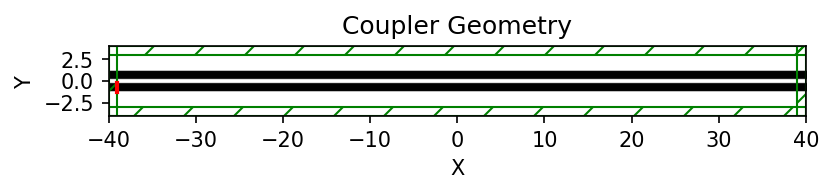

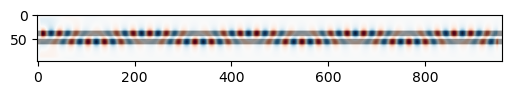

In [2]:
# Start by defining the simulation domain

sx = 80
sy = 8

# Meep function to define the domain. 
# Third dimension is 0 since we are in a 2D simulation We can even avoid declaring the 3rd dimension. 

cell = mp.Vector3(sx, sy)

# Now we define the geomtry, all the blocks making up our waveguide

center = 0

gap = 1.4

width = 1

geometry = [
       # Guide 1
           mp.Block(
           mp.Vector3(mp.inf, 1, mp.inf), #
           center = mp.Vector3(center,gap/2,0),  
           material = mp.Medium(index=3.)),
        # Guide 2
           mp.Block(
           mp.Vector3(mp.inf, width, mp.inf), #
           center = mp.Vector3(center,-gap/2,0),  
           material = mp.Medium(index=3.)),] 

# Now define a source

sources = [mp.Source(mp.ContinuousSource(frequency=0.15), # Type of source
                     component = mp.Ez, 
                     size = mp.Vector3(0,width,0),
                     center = mp.Vector3(-sx/2 +1,-gap/2))] # Position

# Boundary condition, we use PML layer

pml_layer = [mp.PML(1.0) ] # The pml thickness should be of the order of the wavelength 

resolution = 12

a = 1 * 1e-6 # Length scale to convert to SI units. N.B. i checked, with this scale the size makes sense with reality of fabrication

# Simulation

sim = mp.Simulation(
      cell_size = cell,
      boundary_layers = pml_layer,
      geometry = geometry,
      sources = sources,
      resolution = resolution)

sim.run(until = 300) # RUn for 200 time steps

# Plot the dielectric structure we definded

plt.figure(dpi=150)
plt.title("Coupler Geometry")
sim.plot2D()
plt.savefig("coupler_geometry.png", dpi = 150, format = "png")
plt.show()

# Visualisation of the result

ez_data = sim.get_array(center = mp.Vector3(), size=cell, component=mp.Ez)
eps_data = sim.get_array(center = mp.Vector3(), size=cell, component=mp.Dielectric)
plt.figure(dpi=100)
plt.imshow(eps_data.transpose(), interpolation = 'spline36', cmap = 'binary')
plt.imshow(ez_data.transpose(), interpolation = 'spline36', cmap = 'RdBu', alpha = 0.6)
plt.show()

In [3]:
# Get field component 

sensor = mp.Vector3(sx, sy/8)

field_up = np.array(sim.get_array(center=mp.Vector3(0, gap/2,0), size=sensor, component=mp.Ez))
field_down = np.array(sim.get_array(center=mp.Vector3(0, -gap/2,0), size=sensor, component=mp.Ez))


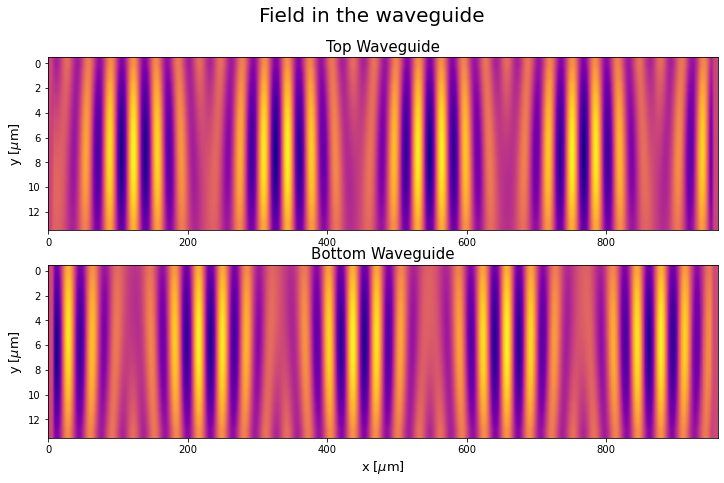

In [4]:
# Plot it with a colormap

fig, ax = plt.subplots(2,1, figsize=(12,7))

fig.suptitle("Field in the waveguide", fontsize=20)

ax[0].imshow(field_up.T, cmap="plasma")
ax[0].set_aspect("auto") # NB in this way the pixels of the colormap are not square
ax[0].set_ylabel(r"y [$\mu$m]", fontsize=13)
ax[0].set_title("Top Waveguide", fontsize=15)

ax[1].imshow(field_down.T, cmap="plasma")
ax[1].set_aspect("auto")
ax[1].set_xlabel(r"x [$\mu$m]", fontsize=13)
ax[1].set_ylabel(r"y [$\mu$m]", fontsize=13)
ax[1].set_title("Bottom Waveguide", fontsize=15)

plt.savefig("field_profile.png", dpi = 150, format = "png")

plt.show()

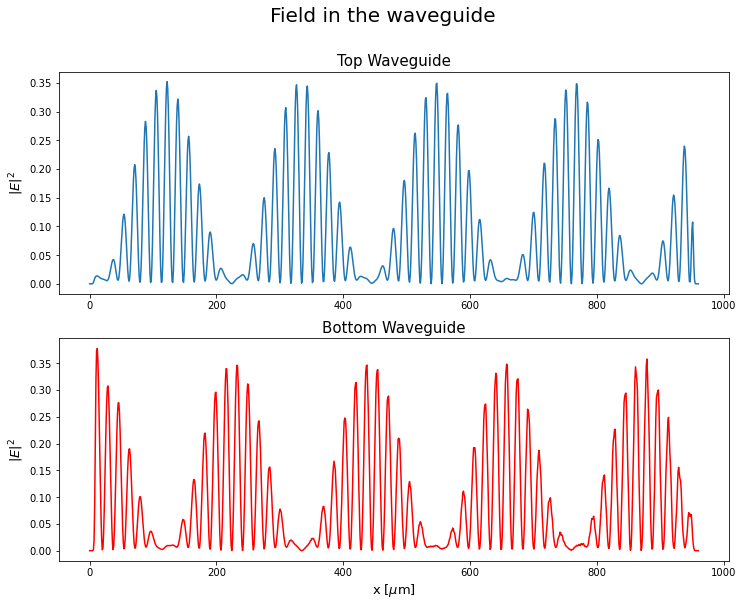

In [5]:
# Plot the Field in the Guide (mod^2)

field_up_0 = np.trapz(field_up**2, axis = 1)
field_down_0 = np.trapz(field_down**2, axis = 1)

x_vec_si = np.linspace(0,len(field_up.T[1,:]),len(field_up.T[1,:])) * a * 1e6 # x vector in si, made such that the whole coupler is approximately 1mm long

# Notice. From my understanding, real couplers are about 400 microns. Explain your length choice with the needs of this study


fig, ax = plt.subplots(2,1, figsize=(12,9))

fig.suptitle("Field in the waveguide", fontsize=20)

ax[0].plot(x_vec_si, field_up_0)
ax[0].set_ylabel(r"$|E|^2$", fontsize=13)
ax[0].set_title("Top Waveguide", fontsize=15)

ax[1].plot(x_vec_si, field_down_0, color = "r")
ax[1].set_xlabel(r"x [$\mu$m]", fontsize=13)
ax[1].set_ylabel(r"$|E|^2$", fontsize=13)
ax[1].set_title("Bottom Waveguide", fontsize=15)

plt.savefig("field_mod2.png", dpi = 150, format = "png")

plt.show()

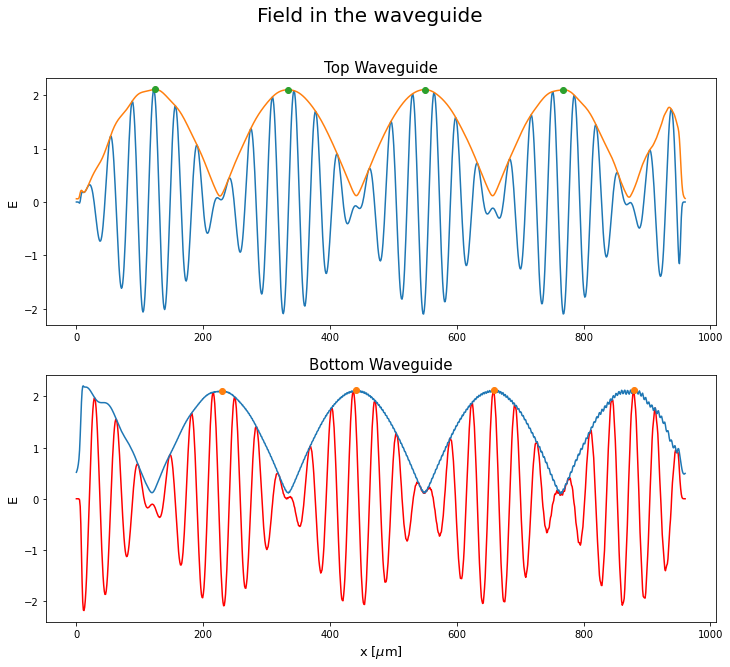

In [6]:
# Finding the Hilbert transform of the fields

field_up_0 = np.trapz(field_up, axis = 1)
field_down_0 = np.trapz(field_down, axis = 1)

envelope_down = np.abs(sp.hilbert(field_down_0))
envelope_up = np.abs(sp.hilbert(field_up_0))

x = np.linspace(0,sx,sx*resolution)

# Finding peaks with scipy function

height_up_min = 0.9 * np.max(envelope_up)
height_up_max = 1 * np.max(envelope_up)
height_down_min = 0.9 * np.max(envelope_down[np.argmax(envelope_down[0:int(np.floor(len(envelope_down)/3))])*2:])
height_down_max = 1 * np.max(envelope_down[np.argmax(envelope_down[0:int(np.floor(len(envelope_down)/3))])*2:])

width = 50

peaks_up = sp.find_peaks(envelope_up, height = (height_up_min, height_up_max), width = width)[0]
peaks_down = sp.find_peaks(envelope_down, height = (height_down_min, height_down_max), width = width)[0]


# Computing the coupling length 


while (len(peaks_up) != len(peaks_down)):

    if (len(peaks_up) < len(peaks_down)):

        peaks_up = np.delete(peaks_up, 0)

    elif (len(peaks_down) > len(peaks_up)):

        peaks_down = np.delete(peaks_down, len(peaks_down)-1)
    

dist = np.mean(np.abs(peaks_up - peaks_down))
d_dist = np.std(np.abs(peaks_up - peaks_down))

Lc = dist * (sx/len(x))
d_Lc = d_dist * (sx/len(x))

# FIGURE

fig, ax = plt.subplots(2,1, figsize=(12,10))

fig.suptitle("Field in the waveguide", fontsize = 20)

ax[0].plot(x_vec_si, field_up_0)
ax[0].plot(x_vec_si, envelope_up)
ax[0].plot(x_vec_si[peaks_up], envelope_up[peaks_up], "o")
ax[0].set_ylabel("E", fontsize = 13)
ax[0].set_title("Top Waveguide", fontsize = 15)

ax[1].plot(x_vec_si, field_down_0, color = "r")
ax[1].plot(x_vec_si, envelope_down)
ax[1].plot(x_vec_si[peaks_down], envelope_down[peaks_down], "o")
ax[1].set_xlabel(r"x [$\mu$m]", fontsize = 13)
ax[1].set_ylabel("E", fontsize = 13)
ax[1].set_title("Bottom Waveguide", fontsize = 15)

plt.savefig("field_envelope_peaks.png", dpi = 150, format = "png")

plt.show()

### Now iterate the process

We want to repeat the simulation for different values of the gap between waveguides and then find the dependence of the coupling length on the gap.

In [54]:
# Iterative procedure 

# Array for values of the gap to test 
gs = 200
gap_array = np.linspace(1.0,1.9,gs)

# Start by defining the simulation domain
# The easiest and least efficient way is to use constants

sx = 160
sy = 8

# Meep function to define the domain. Third dimension is 0 since we are in a 2D simulation. We can even avoid declaring the 3rd dimension. 

cell = mp.Vector3(sx, sy)

center = 0

width = 1

# Boundary condition, we use PML layer

pml_layer = [mp.PML(1.0) ] # The pml thickness should be of the order of the wavelength 

resolution = 12

# Subvolume for the sensor 

sensor = mp.Vector3(sx, sy/8)

# Wectors to store the coupling length

Lc = np.zeros(gs)
d_Lc = np.zeros(gs)

i = 0

for gap in gap_array: 
    
    geometry = [
       # Guide 1
           mp.Block(
           mp.Vector3(mp.inf, 1, mp.inf), #
           center = mp.Vector3(center,gap/2,0),  
           material = mp.Medium(epsilon=12.)),
        # Guide 2
           mp.Block(
           mp.Vector3(mp.inf, width, mp.inf), #
           center = mp.Vector3(center,-gap/2,0),  
           material = mp.Medium(epsilon=12.)),] 

    # Now define a source

    sources = [mp.Source(mp.ContinuousSource(frequency=0.15), # Type of source
                         component = mp.Ez, 
                         size = mp.Vector3(0,width,0),
                         center = mp.Vector3(-7,-gap/2))] # Position

    # Simulation
    
    sim = mp.Simulation(
          cell_size = cell,
          boundary_layers = pml_layer,
          geometry = geometry,
          sources = sources,
          resolution = resolution)
    
    sim.run(until = 300) # RUn for 300 time steps
    
    # Get field component

    field_up = np.array(sim.get_array(center=mp.Vector3(0, gap/2,0), size=sensor, component=mp.Ez))
    field_down = np.array(sim.get_array(center=mp.Vector3(0, -gap/2,0), size=sensor, component=mp.Ez))
    
    # Integrate along y axis and Hilbert transform
    
    field_up_0 = np.trapz(field_up, axis = 1) #/ (sy/8)
    field_down_0 = np.trapz(field_down, axis = 1) #/ (sy/8)

    envelope_down = np.abs(sp.hilbert(field_down_0))
    envelope_up = np.abs(sp.hilbert(field_up_0))
    
    x = np.linspace(0,sx,sx*10)
   
    # Finding peaks with scipy function

    height_up_min = 0.9 * np.max(envelope_up)
    height_up_max = 1 * np.max(envelope_up)
    height_down_min = 0.9 * np.max(envelope_down[np.argmax(envelope_down[0:int(np.floor(len(envelope_down)/3))])*2:])
    height_down_max = 1 * np.max(envelope_down[np.argmax(envelope_down[0:int(np.floor(len(envelope_down)/3))])*2:])

    pk_width = 50

    peaks_up = sp.find_peaks(envelope_up, height = (height_up_min, height_up_max), width = pk_width)[0]
    peaks_down = sp.find_peaks(envelope_down, height = (height_down_min, height_down_max), width = pk_width)[0]

    # Computing the coupling length 
    
    while (len(peaks_up) != len(peaks_down)):

        if (len(peaks_up) > len(peaks_down)):

            peaks_up = np.delete(peaks_up, 0)

        elif (len(peaks_down) > len(peaks_up)):
        
            peaks_down = np.delete(peaks_down, len(peaks_down)-1)

    dist = np.mean(np.abs(peaks_up - peaks_down))
    d_dist = np.std(np.abs(peaks_up - peaks_down))

    Lc[i] = dist * (sx/len(x))
    d_Lc[i] = d_dist * (sx/len(x))
    
    i += 1
    

-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.304346 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 143.0/300.0 = 47.7% done in 4.0s, 4.4s to go
on time step 3437 (time=143.208), 0.00116431 s/step
Meep progress: 288.66666666666663/300.0 = 96.2% done in 8.0s, 0.3s to go
on time step 6935 (time=288.958), 0.0011436 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000242949 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.502261,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.502261,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.293965 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 144.45833333333331/300.0 = 48.2% done in 4.0s, 4.3s to go
on time step 3474 (time=144.75), 0.00115145 s/step
Meep progress: 286.91666666666663/300.0 = 95.6% done in 8.0s, 0.4s to go
on time step 6893 (time=287.208), 0.00117008 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000242949 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.504523,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.504523,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.297832 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 146.20833333333331/300.0 = 48.7% done in 4.0s, 4.2s to go
on time step 3515 (time=146.458), 0.00113824 s/step
Meep progress: 294.7083333333333/300.0 = 98.2% done in 8.0s, 0.1s to go
on time step 7080 (time=295), 0.00112221 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274897 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.506784,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.506784,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.298304 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 146.125/300.0 = 48.7% done in 4.0s, 4.2s to go
on time step 3513 (time=146.375), 0.0011388 s/step
Meep progress: 294.875/300.0 = 98.3% done in 8.0s, 0.1s to go
on time step 7083 (time=295.125), 0.00112059 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00030303 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.509045,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.509045,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.308902 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 147.33333333333331/300.0 = 49.1% done in 4.0s, 4.1s to go
on time step 3541 (time=147.542), 0.00112975 s/step
Meep progress: 294.125/300.0 = 98.0% done in 8.0s, 0.2s to go
on time step 7063 (time=294.292), 0.00113586 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000279188 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.511307,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.511307,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.296805 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 146.5/300.0 = 48.8% done in 4.0s, 4.2s to go
on time step 3521 (time=146.708), 0.00113606 s/step
Meep progress: 294.91666666666663/300.0 = 98.3% done in 8.0s, 0.1s to go
on time step 7084 (time=295.167), 0.00112286 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000242949 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.513568,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.513568,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.29466 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 147.70833333333331/300.0 = 49.2% done in 4.0s, 4.1s to go
on time step 3550 (time=147.917), 0.00112689 s/step
Meep progress: 296.9583333333333/300.0 = 99.0% done in 8.0s, 0.1s to go
on time step 7132 (time=297.167), 0.00111671 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000292063 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.515829,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.515829,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.294766 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 137.125/300.0 = 45.7% done in 4.0s, 4.8s to go
on time step 3295 (time=137.292), 0.00121405 s/step
Meep progress: 277.16666666666663/300.0 = 92.4% done in 8.0s, 0.7s to go
on time step 6657 (time=277.375), 0.00119018 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000243902 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.51809,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.51809,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.308052 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 143.70833333333331/300.0 = 47.9% done in 4.0s, 4.4s to go
on time step 3452 (time=143.833), 0.00115899 s/step
Meep progress: 293.66666666666663/300.0 = 97.9% done in 8.0s, 0.2s to go
on time step 7052 (time=293.833), 0.00111116 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000289917 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.520352,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.520352,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.303445 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 143.625/300.0 = 47.9% done in 4.0s, 4.4s to go
on time step 3453 (time=143.875), 0.00115874 s/step
Meep progress: 290.29166666666663/300.0 = 96.8% done in 8.0s, 0.3s to go
on time step 6975 (time=290.625), 0.00113583 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.522613,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.522613,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.295201 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 147.91666666666666/300.0 = 49.3% done in 4.0s, 4.1s to go
on time step 3555 (time=148.125), 0.00112552 s/step
Meep progress: 296.5/300.0 = 98.8% done in 8.0s, 0.1s to go
on time step 7119 (time=296.625), 0.00112247 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000568151 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.524874,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.524874,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.298513 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 148.16666666666666/300.0 = 49.4% done in 4.0s, 4.1s to go
on time step 3560 (time=148.333), 0.00112376 s/step
Meep progress: 291.29166666666663/300.0 = 97.1% done in 8.0s, 0.2s to go
on time step 6995 (time=291.458), 0.00116471 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000246048 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.527136,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.527136,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.344541 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 138.875/300.0 = 46.3% done in 4.0s, 4.6s to go
on time step 3339 (time=139.125), 0.00119804 s/step
Meep progress: 288.16666666666663/300.0 = 96.1% done in 8.0s, 0.3s to go
on time step 6922 (time=288.417), 0.0011164 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.529397,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.529397,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.295234 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 147.08333333333331/300.0 = 49.0% done in 4.0s, 4.2s to go
on time step 3535 (time=147.292), 0.00113162 s/step
Meep progress: 296.41666666666663/300.0 = 98.8% done in 8.0s, 0.1s to go
on time step 7119 (time=296.625), 0.0011161 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.531658,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.531658,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.294911 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 146.58333333333331/300.0 = 48.9% done in 4.0s, 4.2s to go
on time step 3522 (time=146.75), 0.00113575 s/step
Meep progress: 296.8333333333333/300.0 = 98.9% done in 8.0s, 0.1s to go
on time step 7129 (time=297.042), 0.00110932 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000361919 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.53392,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.53392,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.293729 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 145.83333333333331/300.0 = 48.6% done in 4.0s, 4.2s to go
on time step 3505 (time=146.042), 0.00114145 s/step
Meep progress: 293.2083333333333/300.0 = 97.7% done in 8.0s, 0.2s to go
on time step 7043 (time=293.458), 0.0011309 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00029707 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.536181,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.536181,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.301967 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 146.875/300.0 = 49.0% done in 4.0s, 4.2s to go
on time step 3532 (time=147.167), 0.00113277 s/step
Meep progress: 296.54166666666663/300.0 = 98.8% done in 8.0s, 0.1s to go
on time step 7125 (time=296.875), 0.00111351 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00028801 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.538442,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.538442,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.293394 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 147.83333333333331/300.0 = 49.3% done in 4.0s, 4.1s to go
on time step 3553 (time=148.042), 0.00112601 s/step
Meep progress: 296.0/300.0 = 98.7% done in 8.0s, 0.1s to go
on time step 7110 (time=296.25), 0.00112458 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000333071 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.540704,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.540704,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.292929 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 147.79166666666666/300.0 = 49.3% done in 4.0s, 4.1s to go
on time step 3552 (time=148), 0.00112635 s/step
Meep progress: 296.9583333333333/300.0 = 99.0% done in 8.0s, 0.1s to go
on time step 7132 (time=297.167), 0.00111735 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000244141 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.542965,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.542965,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.318319 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 148.25/300.0 = 49.4% done in 4.0s, 4.1s to go
on time step 3563 (time=148.458), 0.00112295 s/step
Meep progress: 298.125/300.0 = 99.4% done in 8.0s, 0.1s to go
on time step 7161 (time=298.375), 0.00111178 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000245094 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.545226,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.545226,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.319702 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 147.54166666666666/300.0 = 49.2% done in 4.0s, 4.1s to go
on time step 3547 (time=147.792), 0.00112798 s/step
Meep progress: 297.16666666666663/300.0 = 99.1% done in 8.0s, 0.1s to go
on time step 7139 (time=297.458), 0.0011138 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.547487,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.547487,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.320533 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 146.08333333333331/300.0 = 48.7% done in 4.0s, 4.2s to go
on time step 3511 (time=146.292), 0.00113934 s/step
Meep progress: 295.125/300.0 = 98.4% done in 8.0s, 0.1s to go
on time step 7089 (time=295.375), 0.00111822 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000243187 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.549749,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.549749,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.321322 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 147.08333333333331/300.0 = 49.0% done in 4.0s, 4.2s to go
on time step 3535 (time=147.292), 0.0011316 s/step
Meep progress: 296.4583333333333/300.0 = 98.8% done in 8.0s, 0.1s to go
on time step 7120 (time=296.667), 0.00111589 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000230074 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.55201,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.55201,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.323369 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 147.20833333333331/300.0 = 49.1% done in 4.0s, 4.2s to go
on time step 3540 (time=147.5), 0.00113004 s/step
Meep progress: 277.8333333333333/300.0 = 92.6% done in 8.0s, 0.6s to go
on time step 6674 (time=278.083), 0.00127669 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000472069 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.554271,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.554271,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.341252 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 128.375/300.0 = 42.8% done in 4.0s, 5.3s to go
on time step 3086 (time=128.583), 0.00129639 s/step
Meep progress: 265.0/300.0 = 88.3% done in 8.0s, 1.1s to go
on time step 6366 (time=265.25), 0.00121984 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000269175 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.556533,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.556533,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.315744 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 144.125/300.0 = 48.0% done in 4.0s, 4.3s to go
on time step 3463 (time=144.292), 0.00115533 s/step
Meep progress: 290.8333333333333/300.0 = 96.9% done in 8.0s, 0.3s to go
on time step 6984 (time=291), 0.00113611 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000404119 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.558794,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.558794,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.313977 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 146.29166666666666/300.0 = 48.8% done in 4.0s, 4.2s to go
on time step 3517 (time=146.542), 0.0011375 s/step
Meep progress: 271.79166666666663/300.0 = 90.6% done in 8.0s, 0.8s to go
on time step 6528 (time=272), 0.00132858 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.561055,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.561055,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.339864 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 124.41666666666666/300.0 = 41.5% done in 4.0s, 5.6s to go
on time step 2990 (time=124.583), 0.0013379 s/step
Meep progress: 252.125/300.0 = 84.0% done in 8.0s, 1.5s to go
on time step 6055 (time=252.292), 0.00130547 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000571012 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.563317,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.563317,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.342828 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 125.29166666666666/300.0 = 41.8% done in 4.0s, 5.6s to go
on time step 3012 (time=125.5), 0.00132839 s/step
Meep progress: 251.41666666666666/300.0 = 83.8% done in 8.0s, 1.5s to go
on time step 6038 (time=251.583), 0.00132191 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000306129 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.565578,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.565578,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.339985 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 127.375/300.0 = 42.5% done in 4.0s, 5.4s to go
on time step 3062 (time=127.583), 0.00130671 s/step
Meep progress: 254.83333333333331/300.0 = 84.9% done in 8.0s, 1.4s to go
on time step 6122 (time=255.083), 0.00130747 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000304937 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.567839,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.567839,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.334567 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 125.625/300.0 = 41.9% done in 4.0s, 5.6s to go
on time step 3017 (time=125.708), 0.00132592 s/step
Meep progress: 252.41666666666666/300.0 = 84.1% done in 8.0s, 1.5s to go
on time step 6063 (time=252.625), 0.00131343 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000402927 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.570101,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.570101,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.343008 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 122.375/300.0 = 40.8% done in 4.0s, 5.8s to go
on time step 2941 (time=122.542), 0.00136017 s/step
Meep progress: 246.25/300.0 = 82.1% done in 8.0s, 1.7s to go
on time step 5916 (time=246.5), 0.00134508 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000500917 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.572362,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.572362,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.332898 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 122.08333333333333/300.0 = 40.7% done in 4.0s, 5.8s to go
on time step 2934 (time=122.25), 0.00136388 s/step
Meep progress: 227.66666666666666/300.0 = 75.9% done in 8.0s, 2.5s to go
on time step 5469 (time=227.875), 0.00157814 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.574623,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.574623,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.354269 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 117.79166666666666/300.0 = 39.3% done in 4.0s, 6.2s to go
on time step 2832 (time=118), 0.00141265 s/step
Meep progress: 256.0/300.0 = 85.3% done in 8.0s, 1.4s to go
on time step 6150 (time=256.25), 0.00120555 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.576884,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.576884,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.333315 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 137.54166666666666/300.0 = 45.8% done in 4.0s, 4.7s to go
on time step 3306 (time=137.75), 0.00121009 s/step
Meep progress: 264.625/300.0 = 88.2% done in 8.0s, 1.1s to go
on time step 6358 (time=264.917), 0.00131083 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000332832 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.579146,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.579146,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.334871 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 133.20833333333331/300.0 = 44.4% done in 4.0s, 5.0s to go
on time step 3199 (time=133.292), 0.00125048 s/step
Meep progress: 264.41666666666663/300.0 = 88.1% done in 8.0s, 1.1s to go
on time step 6351 (time=264.625), 0.00126946 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000242949 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.581407,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.581407,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.316276 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 127.125/300.0 = 42.4% done in 4.0s, 5.4s to go
on time step 3055 (time=127.292), 0.00130945 s/step
Meep progress: 266.375/300.0 = 88.8% done in 8.0s, 1.0s to go
on time step 6400 (time=266.667), 0.00119586 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256777 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.583668,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.583668,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.325144 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 139.83333333333331/300.0 = 46.6% done in 4.0s, 4.6s to go
on time step 3363 (time=140.125), 0.00118947 s/step
Meep progress: 283.125/300.0 = 94.4% done in 8.0s, 0.5s to go
on time step 6802 (time=283.417), 0.0011632 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.58593,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.58593,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.317158 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 133.95833333333331/300.0 = 44.7% done in 4.0s, 5.0s to go
on time step 3219 (time=134.125), 0.0012427 s/step
Meep progress: 267.0833333333333/300.0 = 89.0% done in 8.0s, 1.0s to go
on time step 6413 (time=267.208), 0.0012524 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000244856 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.588191,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.588191,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.318296 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 135.125/300.0 = 45.0% done in 4.0s, 4.9s to go
on time step 3247 (time=135.292), 0.00123213 s/step
Meep progress: 271.125/300.0 = 90.4% done in 8.0s, 0.9s to go
on time step 6512 (time=271.333), 0.00122561 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000377893 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.590452,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.590452,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.314873 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 133.91666666666666/300.0 = 44.6% done in 4.0s, 5.0s to go
on time step 3219 (time=134.125), 0.00124272 s/step
Meep progress: 276.25/300.0 = 92.1% done in 8.0s, 0.7s to go
on time step 6635 (time=276.458), 0.00117107 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000302076 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.592714,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.592714,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.317176 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 136.66666666666666/300.0 = 45.6% done in 4.0s, 4.8s to go
on time step 3284 (time=136.833), 0.00121803 s/step
Meep progress: 279.8333333333333/300.0 = 93.3% done in 8.0s, 0.6s to go
on time step 6721 (time=280.042), 0.00116429 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000460148 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.594975,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.594975,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.330627 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 136.91666666666666/300.0 = 45.6% done in 4.0s, 4.8s to go
on time step 3292 (time=137.167), 0.00121529 s/step
Meep progress: 267.4583333333333/300.0 = 89.2% done in 8.0s, 1.0s to go
on time step 6423 (time=267.625), 0.00127764 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000323057 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.597236,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.597236,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.341785 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 136.41666666666666/300.0 = 45.5% done in 4.0s, 4.8s to go
on time step 3278 (time=136.583), 0.00122043 s/step
Meep progress: 279.29166666666663/300.0 = 93.1% done in 8.0s, 0.6s to go
on time step 6707 (time=279.458), 0.00116665 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.599497,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.599497,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.316289 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 128.58333333333331/300.0 = 42.9% done in 4.0s, 5.3s to go
on time step 3091 (time=128.792), 0.00129443 s/step
Meep progress: 247.125/300.0 = 82.4% done in 8.0s, 1.7s to go
on time step 5936 (time=247.333), 0.00140616 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.601759,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.601759,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.313723 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 128.04166666666666/300.0 = 42.7% done in 4.0s, 5.4s to go
on time step 3077 (time=128.208), 0.0013003 s/step
Meep progress: 251.75/300.0 = 83.9% done in 8.0s, 1.5s to go
on time step 6046 (time=251.917), 0.00134729 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.60402,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.60402,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.314009 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 131.70833333333331/300.0 = 43.9% done in 4.0s, 5.1s to go
on time step 3165 (time=131.875), 0.00126394 s/step
Meep progress: 273.375/300.0 = 91.1% done in 8.0s, 0.8s to go
on time step 6566 (time=273.583), 0.00117629 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.606281,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.606281,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.352148 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 141.625/300.0 = 47.2% done in 4.0s, 4.5s to go
on time step 3404 (time=141.833), 0.00117548 s/step
Meep progress: 280.625/300.0 = 93.5% done in 8.0s, 0.6s to go
on time step 6741 (time=280.875), 0.00119872 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.608543,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.608543,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.314124 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 141.58333333333331/300.0 = 47.2% done in 4.0s, 4.5s to go
on time step 3404 (time=141.833), 0.00117537 s/step
Meep progress: 267.41666666666663/300.0 = 89.1% done in 8.0s, 1.0s to go
on time step 6422 (time=267.583), 0.00132563 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000444174 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.610804,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.610804,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.33566 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 138.66666666666666/300.0 = 46.2% done in 4.0s, 4.7s to go
on time step 3333 (time=138.875), 0.00120012 s/step
Meep progress: 256.75/300.0 = 85.6% done in 8.0s, 1.3s to go
on time step 6166 (time=256.917), 0.00141309 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000391006 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.613065,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.613065,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.318348 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 137.41666666666666/300.0 = 45.8% done in 4.0s, 4.7s to go
on time step 3302 (time=137.583), 0.00121153 s/step
Meep progress: 267.29166666666663/300.0 = 89.1% done in 8.0s, 1.0s to go
on time step 6418 (time=267.417), 0.00128397 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000244141 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.615327,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.615327,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.314216 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 133.375/300.0 = 44.5% done in 4.0s, 5.0s to go
on time step 3204 (time=133.5), 0.00124877 s/step
Meep progress: 235.45833333333331/300.0 = 78.5% done in 8.0s, 2.2s to go
on time step 5655 (time=235.625), 0.00163219 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.617588,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.617588,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.368926 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 102.25/300.0 = 34.1% done in 4.0s, 7.7s to go
on time step 2457 (time=102.375), 0.00162863 s/step
Meep progress: 195.29166666666666/300.0 = 65.1% done in 8.0s, 4.3s to go
on time step 4691 (time=195.458), 0.00179135 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.619849,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.619849,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.342675 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 105.58333333333333/300.0 = 35.2% done in 4.0s, 7.4s to go
on time step 2537 (time=105.708), 0.0015773 s/step
Meep progress: 206.70833333333331/300.0 = 68.9% done in 8.0s, 3.6s to go
on time step 4968 (time=207), 0.00164618 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.622111,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.622111,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.34059 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 126.75/300.0 = 42.2% done in 4.0s, 5.5s to go
on time step 3048 (time=127), 0.00131257 s/step
Meep progress: 249.875/300.0 = 83.3% done in 8.0s, 1.6s to go
on time step 6002 (time=250.083), 0.00135445 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000276089 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.624372,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.624372,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.353273 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 113.70833333333333/300.0 = 37.9% done in 4.0s, 6.6s to go
on time step 2733 (time=113.875), 0.00146371 s/step
Meep progress: 229.375/300.0 = 76.5% done in 8.0s, 2.5s to go
on time step 5510 (time=229.583), 0.00144068 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000370026 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.626633,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.626633,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.344178 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 113.16666666666666/300.0 = 37.7% done in 4.0s, 6.6s to go
on time step 2721 (time=113.375), 0.00147006 s/step
Meep progress: 220.375/300.0 = 73.5% done in 8.0s, 2.9s to go
on time step 5294 (time=220.583), 0.00155524 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000533819 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.628894,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.628894,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.450521 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 110.0/300.0 = 36.7% done in 4.0s, 6.9s to go
on time step 2645 (time=110.208), 0.00151232 s/step
Meep progress: 222.75/300.0 = 74.2% done in 8.0s, 2.8s to go
on time step 5351 (time=222.958), 0.00147842 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000230074 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.631156,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.631156,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.382805 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 125.375/300.0 = 41.8% done in 4.0s, 5.6s to go
on time step 3013 (time=125.542), 0.00132768 s/step
Meep progress: 259.66666666666663/300.0 = 86.6% done in 8.0s, 1.2s to go
on time step 6237 (time=259.875), 0.00124106 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000242949 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.633417,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.633417,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.331979 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 141.125/300.0 = 47.0% done in 4.0s, 4.5s to go
on time step 3391 (time=141.292), 0.00117967 s/step
Meep progress: 277.4583333333333/300.0 = 92.5% done in 8.0s, 0.7s to go
on time step 6664 (time=277.667), 0.00122229 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000230074 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.635678,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.635678,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.303613 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 148.5/300.0 = 49.5% done in 4.0s, 4.1s to go
on time step 3568 (time=148.667), 0.00112108 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248194 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.63794,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.63794,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.30723 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 149.25/300.0 = 49.8% done in 4.0s, 4.0s to go
on time step 3587 (time=149.458), 0.00111535 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.640201,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.640201,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.305803 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 145.04166666666666/300.0 = 48.3% done in 4.0s, 4.3s to go
on time step 3486 (time=145.25), 0.00114746 s/step
Meep progress: 263.16666666666663/300.0 = 87.7% done in 8.0s, 1.1s to go
on time step 6321 (time=263.375), 0.00141115 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000231028 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.642462,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.642462,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.320076 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 141.04166666666666/300.0 = 47.0% done in 4.0s, 4.5s to go
on time step 3388 (time=141.167), 0.00118066 s/step
Meep progress: 284.66666666666663/300.0 = 94.9% done in 8.0s, 0.4s to go
on time step 6836 (time=284.833), 0.00116026 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000428915 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.644724,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.644724,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.313364 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 143.625/300.0 = 47.9% done in 4.0s, 4.4s to go
on time step 3453 (time=143.875), 0.00115895 s/step
Meep progress: 278.79166666666663/300.0 = 92.9% done in 8.0s, 0.6s to go
on time step 6697 (time=279.042), 0.00123313 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000343084 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.646985,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.646985,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.309839 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 128.375/300.0 = 42.8% done in 4.0s, 5.3s to go
on time step 3087 (time=128.625), 0.00129599 s/step
Meep progress: 259.375/300.0 = 86.5% done in 8.0s, 1.3s to go
on time step 6232 (time=259.667), 0.00127219 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000230789 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.649246,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.649246,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.374429 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 122.83333333333333/300.0 = 40.9% done in 4.0s, 5.8s to go
on time step 2955 (time=123.125), 0.00135395 s/step
Meep progress: 254.20833333333331/300.0 = 84.7% done in 8.0s, 1.4s to go
on time step 6107 (time=254.458), 0.00126914 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000430822 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.651508,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.651508,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.310991 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 141.625/300.0 = 47.2% done in 4.0s, 4.5s to go
on time step 3403 (time=141.792), 0.0011757 s/step
Meep progress: 294.2083333333333/300.0 = 98.1% done in 8.0s, 0.2s to go
on time step 7065 (time=294.375), 0.00109244 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000241995 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.653769,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.653769,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.304687 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 152.0/300.0 = 50.7% done in 4.0s, 3.9s to go
on time step 3653 (time=152.208), 0.00109503 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000230074 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.65603,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.65603,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.302318 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 148.16666666666666/300.0 = 49.4% done in 4.0s, 4.1s to go
on time step 3561 (time=148.375), 0.00112347 s/step
Meep progress: 290.875/300.0 = 97.0% done in 8.0s, 0.3s to go
on time step 6986 (time=291.083), 0.00116803 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000243902 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.658291,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.658291,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.334195 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 144.875/300.0 = 48.3% done in 4.0s, 4.3s to go
on time step 3482 (time=145.083), 0.00114879 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.660553,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.660553,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.301242 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 152.70833333333331/300.0 = 50.9% done in 4.0s, 3.9s to go
on time step 3671 (time=152.958), 0.00108976 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000231028 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.662814,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.662814,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.302153 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 138.83333333333331/300.0 = 46.3% done in 4.0s, 4.6s to go
on time step 3338 (time=139.083), 0.0011986 s/step
Meep progress: 289.125/300.0 = 96.4% done in 8.0s, 0.3s to go
on time step 6944 (time=289.333), 0.00110928 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000242949 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.665075,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.665075,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.340953 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 131.08333333333331/300.0 = 43.7% done in 4.0s, 5.2s to go
on time step 3150 (time=131.25), 0.00127017 s/step
Meep progress: 283.8333333333333/300.0 = 94.6% done in 8.0s, 0.5s to go
on time step 6817 (time=284.042), 0.00109101 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265837 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.667337,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.667337,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.305346 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 152.375/300.0 = 50.8% done in 4.0s, 3.9s to go
on time step 3662 (time=152.583), 0.00109239 s/step
Meep progress: 292.7083333333333/300.0 = 97.6% done in 8.0s, 0.2s to go
on time step 7027 (time=292.792), 0.00118872 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000276089 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.669598,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.669598,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.319906 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 145.5/300.0 = 48.5% done in 4.0s, 4.2s to go
on time step 3497 (time=145.708), 0.001144 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000231028 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.671859,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.671859,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.303373 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 148.79166666666666/300.0 = 49.6% done in 4.0s, 4.1s to go
on time step 3575 (time=148.958), 0.00111895 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000242949 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.674121,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.674121,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.301638 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 126.0/300.0 = 42.0% done in 4.0s, 5.5s to go
on time step 3027 (time=126.125), 0.00132147 s/step
Meep progress: 240.95833333333331/300.0 = 80.3% done in 8.0s, 2.0s to go
on time step 5785 (time=241.042), 0.00145053 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000245094 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.676382,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.676382,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.320593 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 138.08333333333331/300.0 = 46.0% done in 4.0s, 4.7s to go
on time step 3319 (time=138.292), 0.00120535 s/step
Meep progress: 272.125/300.0 = 90.7% done in 8.0s, 0.8s to go
on time step 6536 (time=272.333), 0.00124343 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000231028 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.678643,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.678643,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.329218 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 131.91666666666666/300.0 = 44.0% done in 4.0s, 5.1s to go
on time step 3171 (time=132.125), 0.00126168 s/step
Meep progress: 265.0833333333333/300.0 = 88.4% done in 8.0s, 1.1s to go
on time step 6366 (time=265.25), 0.00125207 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000243187 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.680905,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.680905,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.326609 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 129.41666666666666/300.0 = 43.1% done in 4.0s, 5.3s to go
on time step 3111 (time=129.625), 0.00128588 s/step
Meep progress: 260.7083333333333/300.0 = 86.9% done in 8.0s, 1.2s to go
on time step 6263 (time=260.958), 0.00126937 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000241995 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.683166,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.683166,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.321535 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 124.04166666666666/300.0 = 41.3% done in 4.0s, 5.7s to go
on time step 2982 (time=124.25), 0.00134173 s/step
Meep progress: 251.08333333333331/300.0 = 83.7% done in 8.0s, 1.6s to go
on time step 6031 (time=251.292), 0.00131214 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000329018 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.685427,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.685427,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.324986 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 124.58333333333333/300.0 = 41.5% done in 4.0s, 5.6s to go
on time step 2995 (time=124.792), 0.00133587 s/step
Meep progress: 249.20833333333331/300.0 = 83.1% done in 8.0s, 1.6s to go
on time step 5986 (time=249.417), 0.0013374 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000299931 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.687688,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.687688,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.367275 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 97.66666666666666/300.0 = 32.6% done in 4.0s, 8.3s to go
on time step 2348 (time=97.8333), 0.00170366 s/step
Meep progress: 199.95833333333331/300.0 = 66.7% done in 8.0s, 4.0s to go
on time step 4804 (time=200.167), 0.00162907 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277996 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.68995,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.68995,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.342504 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 120.79166666666666/300.0 = 40.3% done in 4.0s, 5.9s to go
on time step 2907 (time=121.125), 0.00137658 s/step
Meep progress: 232.5/300.0 = 77.5% done in 8.0s, 2.3s to go
on time step 5589 (time=232.875), 0.0014918 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000458002 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.692211,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.692211,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.342994 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 115.54166666666666/300.0 = 38.5% done in 4.0s, 6.4s to go
on time step 2776 (time=115.667), 0.00144105 s/step
Meep progress: 233.04166666666666/300.0 = 77.7% done in 8.0s, 2.3s to go
on time step 5596 (time=233.167), 0.00141898 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000246048 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.694472,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.694472,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.328715 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 114.04166666666666/300.0 = 38.0% done in 4.0s, 6.5s to go
on time step 2740 (time=114.167), 0.00145994 s/step
Meep progress: 231.45833333333331/300.0 = 77.2% done in 8.0s, 2.4s to go
on time step 5558 (time=231.583), 0.0014195 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000385046 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.696734,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.696734,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.351225 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 114.58333333333333/300.0 = 38.2% done in 4.0s, 6.5s to go
on time step 2754 (time=114.75), 0.00145338 s/step
Meep progress: 228.79166666666666/300.0 = 76.3% done in 8.0s, 2.5s to go
on time step 5497 (time=229.042), 0.00145842 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.698995,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.698995,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.344809 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 113.33333333333333/300.0 = 37.8% done in 4.0s, 6.6s to go
on time step 2724 (time=113.5), 0.00146898 s/step
Meep progress: 219.04166666666666/300.0 = 73.0% done in 8.0s, 3.0s to go
on time step 5260 (time=219.167), 0.00157753 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000242949 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.701256,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.701256,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.325315 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 123.54166666666666/300.0 = 41.2% done in 4.0s, 5.7s to go
on time step 2969 (time=123.708), 0.00134734 s/step
Meep progress: 251.41666666666666/300.0 = 83.8% done in 8.0s, 1.5s to go
on time step 6038 (time=251.583), 0.0013035 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.703518,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.703518,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.344907 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 110.0/300.0 = 36.7% done in 4.0s, 6.9s to go
on time step 2642 (time=110.083), 0.00151412 s/step
Meep progress: 209.29166666666666/300.0 = 69.8% done in 8.0s, 3.5s to go
on time step 5028 (time=209.5), 0.00167696 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000343084 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.705779,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.705779,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.340646 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 138.25/300.0 = 46.1% done in 4.0s, 4.7s to go
on time step 3323 (time=138.458), 0.00120414 s/step
Meep progress: 279.2083333333333/300.0 = 93.1% done in 8.0s, 0.6s to go
on time step 6707 (time=279.458), 0.00118229 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000245094 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.70804,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.70804,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.315759 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 139.0/300.0 = 46.3% done in 4.0s, 4.6s to go
on time step 3341 (time=139.208), 0.00119735 s/step
Meep progress: 264.9583333333333/300.0 = 88.3% done in 8.0s, 1.1s to go
on time step 6363 (time=265.125), 0.00132388 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000503063 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.710302,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.710302,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.362979 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 119.875/300.0 = 40.0% done in 4.0s, 6.0s to go
on time step 2882 (time=120.083), 0.001388 s/step
Meep progress: 244.20833333333331/300.0 = 81.4% done in 8.0s, 1.8s to go
on time step 5866 (time=244.417), 0.00134092 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000308037 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.712563,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.712563,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.332726 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 135.625/300.0 = 45.2% done in 4.0s, 4.8s to go
on time step 3259 (time=135.792), 0.00122761 s/step
Meep progress: 273.8333333333333/300.0 = 91.3% done in 8.0s, 0.8s to go
on time step 6577 (time=274.042), 0.00120564 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000366926 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.714824,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.714824,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.318552 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 134.29166666666666/300.0 = 44.8% done in 4.0s, 4.9s to go
on time step 3229 (time=134.542), 0.00123902 s/step
Meep progress: 271.4583333333333/300.0 = 90.5% done in 8.0s, 0.8s to go
on time step 6522 (time=271.75), 0.00121496 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.717085,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.717085,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.35528 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 127.79166666666666/300.0 = 42.6% done in 4.0s, 5.4s to go
on time step 3071 (time=127.958), 0.00130279 s/step
Meep progress: 254.04166666666666/300.0 = 84.7% done in 8.0s, 1.4s to go
on time step 6100 (time=254.167), 0.00132088 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000275135 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.719347,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.719347,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.320058 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 105.125/300.0 = 35.0% done in 4.0s, 7.4s to go
on time step 2526 (time=105.25), 0.00158368 s/step
Meep progress: 205.83333333333331/300.0 = 68.6% done in 8.0s, 3.7s to go
on time step 4942 (time=205.917), 0.00165568 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.721608,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.721608,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.426887 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 98.70833333333333/300.0 = 32.9% done in 4.0s, 8.2s to go
on time step 2372 (time=98.8333), 0.00168718 s/step
Meep progress: 208.33333333333331/300.0 = 69.4% done in 8.0s, 3.5s to go
on time step 5006 (time=208.583), 0.00151889 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.723869,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.723869,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.350452 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 125.20833333333333/300.0 = 41.7% done in 4.0s, 5.6s to go
on time step 3010 (time=125.417), 0.0013291 s/step
Meep progress: 258.16666666666663/300.0 = 86.1% done in 8.0s, 1.3s to go
on time step 6200 (time=258.333), 0.0012546 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000461102 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.726131,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.726131,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.357167 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 113.70833333333333/300.0 = 37.9% done in 4.0s, 6.6s to go
on time step 2734 (time=113.917), 0.00146341 s/step
Meep progress: 253.04166666666666/300.0 = 84.3% done in 8.0s, 1.5s to go
on time step 6077 (time=253.208), 0.00119661 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000231028 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.728392,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.728392,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.314573 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 142.16666666666666/300.0 = 47.4% done in 4.0s, 4.4s to go
on time step 3417 (time=142.375), 0.00117082 s/step
Meep progress: 255.875/300.0 = 85.3% done in 8.0s, 1.4s to go
on time step 6145 (time=256.042), 0.00146665 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000375986 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.730653,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.730653,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.337465 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 135.0/300.0 = 45.0% done in 4.0s, 4.9s to go
on time step 3243 (time=135.125), 0.00123374 s/step
Meep progress: 247.58333333333331/300.0 = 82.5% done in 8.0s, 1.7s to go
on time step 5944 (time=247.667), 0.00148117 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00022912 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.732915,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.732915,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.30632 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 99.58333333333333/300.0 = 33.2% done in 4.0s, 8.1s to go
on time step 2393 (time=99.7083), 0.00167233 s/step
Meep progress: 240.20833333333331/300.0 = 80.1% done in 8.0s, 2.0s to go
on time step 5770 (time=240.417), 0.00118449 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.735176,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.735176,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.30477 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 150.41666666666666/300.0 = 50.1% done in 4.0s, 4.0s to go
on time step 3615 (time=150.625), 0.00110654 s/step
Meep progress: 299.0/300.0 = 99.7% done in 8.0s, 0.0s to go
on time step 7181 (time=299.208), 0.00112175 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00039196 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.737437,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.737437,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.304521 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 148.29166666666666/300.0 = 49.4% done in 4.0s, 4.1s to go
on time step 3563 (time=148.458), 0.00112278 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000231028 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.739698,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.739698,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.308449 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 151.20833333333331/300.0 = 50.4% done in 4.0s, 3.9s to go
on time step 3634 (time=151.417), 0.00110083 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000229836 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.74196,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.74196,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.305722 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 152.125/300.0 = 50.7% done in 4.0s, 3.9s to go
on time step 3655 (time=152.292), 0.00109442 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000243187 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.744221,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.744221,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.308345 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 151.54166666666666/300.0 = 50.5% done in 4.0s, 3.9s to go
on time step 3643 (time=151.792), 0.00109819 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.746482,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.746482,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.306518 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 136.625/300.0 = 45.5% done in 4.0s, 4.8s to go
on time step 3283 (time=136.792), 0.00121859 s/step
Meep progress: 280.375/300.0 = 93.5% done in 8.0s, 0.6s to go
on time step 6734 (time=280.583), 0.00115936 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000241995 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.748744,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.748744,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.306628 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 141.16666666666666/300.0 = 47.1% done in 4.0s, 4.5s to go
on time step 3393 (time=141.375), 0.00117894 s/step
Meep progress: 294.8333333333333/300.0 = 98.3% done in 8.0s, 0.1s to go
on time step 7082 (time=295.083), 0.00108448 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000230789 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.751005,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.751005,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.308802 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 151.29166666666666/300.0 = 50.4% done in 4.0s, 3.9s to go
on time step 3636 (time=151.5), 0.00110035 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.753266,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.753266,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.305779 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 150.66666666666666/300.0 = 50.2% done in 4.0s, 4.0s to go
on time step 3621 (time=150.875), 0.00110491 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.755528,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.755528,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.304841 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 146.5/300.0 = 48.8% done in 4.0s, 4.2s to go
on time step 3521 (time=146.708), 0.00113628 s/step
Meep progress: 296.91666666666663/300.0 = 99.0% done in 8.0s, 0.1s to go
on time step 7131 (time=297.125), 0.00110842 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000241041 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.757789,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.757789,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.356257 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 142.54166666666666/300.0 = 47.5% done in 4.0s, 4.4s to go
on time step 3427 (time=142.792), 0.00116737 s/step
Meep progress: 293.0833333333333/300.0 = 97.7% done in 8.0s, 0.2s to go
on time step 7041 (time=293.375), 0.00110698 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.76005,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.76005,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.30316 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 150.125/300.0 = 50.0% done in 4.0s, 4.0s to go
on time step 3608 (time=150.333), 0.00110881 s/step
Meep progress: 288.41666666666663/300.0 = 96.1% done in 8.0s, 0.3s to go
on time step 6926 (time=288.583), 0.00120564 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000242949 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.762312,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.762312,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.331685 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 137.95833333333331/300.0 = 46.0% done in 4.0s, 4.7s to go
on time step 3315 (time=138.125), 0.00120685 s/step
Meep progress: 290.7083333333333/300.0 = 96.9% done in 8.0s, 0.3s to go
on time step 6981 (time=290.875), 0.00109126 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000273943 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.764573,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.764573,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.336566 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 130.91666666666666/300.0 = 43.6% done in 4.0s, 5.2s to go
on time step 3145 (time=131.042), 0.00127186 s/step
Meep progress: 253.41666666666666/300.0 = 84.5% done in 8.0s, 1.5s to go
on time step 6086 (time=253.583), 0.00136018 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000243902 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.766834,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.766834,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.306695 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 149.33333333333331/300.0 = 49.8% done in 4.0s, 4.0s to go
on time step 3590 (time=149.583), 0.00111441 s/step
Meep progress: 276.125/300.0 = 92.0% done in 8.0s, 0.7s to go
on time step 6633 (time=276.375), 0.00131487 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.769095,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.769095,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.376983 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 126.83333333333333/300.0 = 42.3% done in 4.0s, 5.5s to go
on time step 3049 (time=127.042), 0.00131216 s/step
Meep progress: 266.79166666666663/300.0 = 88.9% done in 8.0s, 1.0s to go
on time step 6408 (time=267), 0.00119085 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283957 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.771357,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.771357,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.328727 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 123.41666666666666/300.0 = 41.1% done in 4.0s, 5.7s to go
on time step 2966 (time=123.583), 0.00134895 s/step
Meep progress: 248.20833333333331/300.0 = 82.7% done in 8.0s, 1.7s to go
on time step 5964 (time=248.5), 0.00133456 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.773618,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.773618,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.352354 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 123.20833333333333/300.0 = 41.1% done in 4.0s, 5.7s to go
on time step 2963 (time=123.458), 0.00135038 s/step
Meep progress: 236.0/300.0 = 78.7% done in 8.0s, 2.2s to go
on time step 5671 (time=236.292), 0.00147732 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.775879,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.775879,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.317938 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 106.16666666666666/300.0 = 35.4% done in 4.0s, 7.3s to go
on time step 2551 (time=106.292), 0.00156865 s/step
Meep progress: 237.625/300.0 = 79.2% done in 8.0s, 2.1s to go
on time step 5709 (time=237.875), 0.00126674 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000231028 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.778141,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.778141,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.321632 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 136.66666666666666/300.0 = 45.6% done in 4.0s, 4.8s to go
on time step 3285 (time=136.875), 0.00121773 s/step
Meep progress: 266.0833333333333/300.0 = 88.7% done in 8.0s, 1.0s to go
on time step 6389 (time=266.208), 0.00128879 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271082 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.780402,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.780402,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.355681 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 126.04166666666666/300.0 = 42.0% done in 4.0s, 5.5s to go
on time step 3031 (time=126.292), 0.00132001 s/step
Meep progress: 272.54166666666663/300.0 = 90.8% done in 8.0s, 0.8s to go
on time step 6547 (time=272.792), 0.0011378 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000246048 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.782663,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.782663,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.304311 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 124.5/300.0 = 41.5% done in 4.0s, 5.6s to go
on time step 2991 (time=124.625), 0.00133751 s/step
Meep progress: 250.625/300.0 = 83.5% done in 8.0s, 1.6s to go
on time step 6018 (time=250.75), 0.00132162 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000244856 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.784925,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.784925,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.354125 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 125.125/300.0 = 41.7% done in 4.0s, 5.6s to go
on time step 3008 (time=125.333), 0.00133019 s/step
Meep progress: 250.75/300.0 = 83.6% done in 8.0s, 1.6s to go
on time step 6024 (time=251), 0.00132666 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000242949 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.787186,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.787186,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.328268 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 127.08333333333333/300.0 = 42.4% done in 4.0s, 5.4s to go
on time step 3055 (time=127.292), 0.00130951 s/step
Meep progress: 250.91666666666666/300.0 = 83.6% done in 8.0s, 1.6s to go
on time step 6027 (time=251.125), 0.00134647 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000243187 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.789447,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.789447,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.332041 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 126.08333333333333/300.0 = 42.0% done in 4.0s, 5.5s to go
on time step 3031 (time=126.292), 0.00131978 s/step
Meep progress: 253.125/300.0 = 84.4% done in 8.0s, 1.5s to go
on time step 6078 (time=253.25), 0.00131277 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000331879 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.791709,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.791709,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.38348 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 110.83333333333333/300.0 = 36.9% done in 4.0s, 6.8s to go
on time step 2664 (time=111), 0.00150197 s/step
Meep progress: 223.58333333333331/300.0 = 74.5% done in 8.0s, 2.7s to go
on time step 5370 (time=223.75), 0.00147849 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000433922 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.79397,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.79397,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.364168 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 100.16666666666666/300.0 = 33.4% done in 4.0s, 8.0s to go
on time step 2407 (time=100.292), 0.00166233 s/step
Meep progress: 208.83333333333331/300.0 = 69.6% done in 8.0s, 3.5s to go
on time step 5016 (time=209), 0.00153353 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277042 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.796231,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.796231,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.346562 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 116.04166666666666/300.0 = 38.7% done in 4.0s, 6.3s to go
on time step 2788 (time=116.167), 0.0014348 s/step
Meep progress: 236.83333333333331/300.0 = 78.9% done in 8.0s, 2.1s to go
on time step 5688 (time=237), 0.00137979 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000400066 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.798492,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.798492,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.342926 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 119.41666666666666/300.0 = 39.8% done in 4.0s, 6.0s to go
on time step 2870 (time=119.583), 0.00139399 s/step
Meep progress: 233.625/300.0 = 77.9% done in 8.0s, 2.3s to go
on time step 5610 (time=233.75), 0.00145992 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000287056 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.800754,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.800754,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.364624 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 103.125/300.0 = 34.4% done in 4.0s, 7.6s to go
on time step 2483 (time=103.458), 0.0016112 s/step
Meep progress: 219.33333333333331/300.0 = 73.1% done in 8.0s, 2.9s to go
on time step 5272 (time=219.667), 0.00143452 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000243187 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.803015,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.803015,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.351088 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 113.91666666666666/300.0 = 38.0% done in 4.0s, 6.5s to go
on time step 2739 (time=114.125), 0.00146097 s/step
Meep progress: 252.83333333333331/300.0 = 84.3% done in 8.0s, 1.5s to go
on time step 6075 (time=253.125), 0.00119924 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000231028 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.805276,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.805276,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.311823 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 129.95833333333331/300.0 = 43.3% done in 4.0s, 5.2s to go
on time step 3122 (time=130.083), 0.00128165 s/step
Meep progress: 277.9583333333333/300.0 = 92.7% done in 8.0s, 0.6s to go
on time step 6676 (time=278.167), 0.00112578 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000231028 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.807538,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.807538,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.306343 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 152.95833333333331/300.0 = 51.0% done in 4.0s, 3.8s to go
on time step 3677 (time=153.208), 0.00108801 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000291824 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.809799,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.809799,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.301093 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 154.16666666666666/300.0 = 51.4% done in 4.0s, 3.8s to go
on time step 3705 (time=154.375), 0.00107971 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261784 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.81206,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.81206,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.305047 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 152.58333333333331/300.0 = 50.9% done in 4.0s, 3.9s to go
on time step 3667 (time=152.792), 0.00109093 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000230074 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.814322,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.814322,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.306123 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 144.04166666666666/300.0 = 48.0% done in 4.0s, 4.3s to go
on time step 3462 (time=144.25), 0.00115575 s/step
Meep progress: 271.41666666666663/300.0 = 90.5% done in 8.0s, 0.8s to go
on time step 6519 (time=271.625), 0.00130879 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000287771 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.816583,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.816583,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.338064 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 123.91666666666666/300.0 = 41.3% done in 4.0s, 5.7s to go
on time step 2977 (time=124.042), 0.00134368 s/step
Meep progress: 250.91666666666666/300.0 = 83.6% done in 8.0s, 1.6s to go
on time step 6025 (time=251.042), 0.00131264 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.818844,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.818844,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.335511 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 126.33333333333333/300.0 = 42.1% done in 4.0s, 5.5s to go
on time step 3034 (time=126.417), 0.00131859 s/step
Meep progress: 256.16666666666663/300.0 = 85.4% done in 8.0s, 1.4s to go
on time step 6151 (time=256.292), 0.00128357 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000241995 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.821106,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.821106,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.346329 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 124.66666666666666/300.0 = 41.6% done in 4.0s, 5.6s to go
on time step 2995 (time=124.792), 0.00133585 s/step
Meep progress: 251.16666666666666/300.0 = 83.7% done in 8.0s, 1.6s to go
on time step 6032 (time=251.333), 0.00131718 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283003 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.823367,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.823367,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.340615 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 121.66666666666666/300.0 = 40.6% done in 4.0s, 5.9s to go
on time step 2927 (time=121.958), 0.00136675 s/step
Meep progress: 238.83333333333331/300.0 = 79.6% done in 8.0s, 2.0s to go
on time step 5739 (time=239.125), 0.00142287 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000312805 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.825628,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.825628,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.375667 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 133.54166666666666/300.0 = 44.5% done in 4.0s, 5.0s to go
on time step 3209 (time=133.708), 0.00124697 s/step
Meep progress: 261.3333333333333/300.0 = 87.1% done in 8.0s, 1.2s to go
on time step 6276 (time=261.5), 0.0013045 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247955 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.827889,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.827889,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.344006 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 136.66666666666666/300.0 = 45.6% done in 4.0s, 4.8s to go
on time step 3284 (time=136.833), 0.00121822 s/step
Meep progress: 269.5833333333333/300.0 = 89.9% done in 8.0s, 0.9s to go
on time step 6475 (time=269.792), 0.00125409 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000243902 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.830151,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.830151,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.378793 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 151.54166666666666/300.0 = 50.5% done in 4.0s, 3.9s to go
on time step 3642 (time=151.75), 0.00109843 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.832412,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.832412,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.299083 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 157.58333333333331/300.0 = 52.5% done in 4.0s, 3.6s to go
on time step 3787 (time=157.792), 0.00105656 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.834673,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.834673,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.326001 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 135.91666666666666/300.0 = 45.3% done in 4.0s, 4.8s to go
on time step 3268 (time=136.167), 0.00122425 s/step
Meep progress: 273.25/300.0 = 91.1% done in 8.0s, 0.8s to go
on time step 6565 (time=273.542), 0.00121333 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000243187 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.836935,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.836935,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.34593 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 147.625/300.0 = 49.2% done in 4.0s, 4.1s to go
on time step 3548 (time=147.833), 0.00112757 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.839196,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.839196,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.299353 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 153.70833333333331/300.0 = 51.2% done in 4.0s, 3.8s to go
on time step 3693 (time=153.875), 0.00108337 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247002 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.841457,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.841457,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.317126 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 157.5/300.0 = 52.5% done in 4.0s, 3.6s to go
on time step 3784 (time=157.667), 0.00105735 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000302076 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.843719,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.843719,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.303866 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 157.54166666666666/300.0 = 52.5% done in 4.0s, 3.6s to go
on time step 3787 (time=157.792), 0.00105643 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283003 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.84598,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.84598,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.299468 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 157.25/300.0 = 52.4% done in 4.0s, 3.6s to go
on time step 3779 (time=157.458), 0.00105864 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000375986 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.848241,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.848241,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.300999 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 156.45833333333331/300.0 = 52.2% done in 4.0s, 3.7s to go
on time step 3761 (time=156.708), 0.00106374 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.850503,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.850503,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.303894 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 149.16666666666666/300.0 = 49.7% done in 4.0s, 4.0s to go
on time step 3585 (time=149.375), 0.00111606 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000244141 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.852764,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.852764,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.303404 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 158.20833333333331/300.0 = 52.7% done in 4.0s, 3.6s to go
on time step 3803 (time=158.458), 0.00105189 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000231028 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.855025,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.855025,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.313046 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 157.625/300.0 = 52.5% done in 4.0s, 3.6s to go
on time step 3788 (time=157.833), 0.001056 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000365973 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.857286,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.857286,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.300261 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 152.75/300.0 = 50.9% done in 4.0s, 3.9s to go
on time step 3669 (time=152.875), 0.00109034 s/step
Meep progress: 285.0833333333333/300.0 = 95.0% done in 8.0s, 0.4s to go
on time step 6846 (time=285.25), 0.00125931 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.859548,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.859548,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.333726 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 112.41666666666666/300.0 = 37.5% done in 4.0s, 6.7s to go
on time step 2704 (time=112.667), 0.00147931 s/step
Meep progress: 231.875/300.0 = 77.3% done in 8.0s, 2.4s to go
on time step 5571 (time=232.125), 0.00139531 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.861809,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.861809,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.300698 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 137.33333333333331/300.0 = 45.8% done in 4.0s, 4.7s to go
on time step 3299 (time=137.458), 0.00121268 s/step
Meep progress: 266.25/300.0 = 88.8% done in 8.0s, 1.0s to go
on time step 6395 (time=266.458), 0.00129243 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000242949 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.86407,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.86407,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.336428 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 137.875/300.0 = 46.0% done in 4.0s, 4.7s to go
on time step 3314 (time=138.083), 0.00120738 s/step
Meep progress: 296.375/300.0 = 98.8% done in 8.0s, 0.1s to go
on time step 7119 (time=296.625), 0.0010515 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.866332,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.866332,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.302083 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 150.41666666666666/300.0 = 50.1% done in 4.0s, 4.0s to go
on time step 3614 (time=150.583), 0.00110691 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.868593,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.868593,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.301369 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 157.91666666666666/300.0 = 52.6% done in 4.0s, 3.6s to go
on time step 3796 (time=158.167), 0.00105385 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.870854,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.870854,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.304302 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 158.125/300.0 = 52.7% done in 4.0s, 3.6s to go
on time step 3799 (time=158.292), 0.00105301 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.873116,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.873116,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.299523 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 158.04166666666666/300.0 = 52.7% done in 4.0s, 3.6s to go
on time step 3798 (time=158.25), 0.0010532 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000230789 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.875377,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.875377,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.303983 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 157.54166666666666/300.0 = 52.5% done in 4.0s, 3.6s to go
on time step 3785 (time=157.708), 0.00105688 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000246048 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.877638,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.877638,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.303345 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 157.95833333333331/300.0 = 52.7% done in 4.0s, 3.6s to go
on time step 3796 (time=158.167), 0.001054 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000279903 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.879899,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.879899,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.299405 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 140.91666666666666/300.0 = 47.0% done in 4.0s, 4.5s to go
on time step 3386 (time=141.083), 0.00118145 s/step
Meep progress: 284.04166666666663/300.0 = 94.7% done in 8.0s, 0.4s to go
on time step 6822 (time=284.25), 0.0011645 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00027895 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.882161,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.882161,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.320415 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 146.04166666666666/300.0 = 48.7% done in 4.0s, 4.2s to go
on time step 3509 (time=146.208), 0.00114004 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000353098 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.884422,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.884422,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.299517 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 157.91666666666666/300.0 = 52.6% done in 4.0s, 3.6s to go
on time step 3794 (time=158.083), 0.00105448 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000231981 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.886683,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.886683,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.299479 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 156.125/300.0 = 52.0% done in 4.0s, 3.7s to go
on time step 3751 (time=156.292), 0.00106642 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.888945,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.888945,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.324905 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 123.25/300.0 = 41.1% done in 4.0s, 5.7s to go
on time step 2962 (time=123.417), 0.00135093 s/step
Meep progress: 261.0/300.0 = 87.0% done in 8.0s, 1.2s to go
on time step 6271 (time=261.292), 0.00120902 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000244141 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.891206,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.891206,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.303255 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 134.58333333333331/300.0 = 44.9% done in 4.0s, 4.9s to go
on time step 3236 (time=134.833), 0.00123645 s/step
Meep progress: 263.3333333333333/300.0 = 87.8% done in 8.0s, 1.1s to go
on time step 6326 (time=263.583), 0.00129453 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277042 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.893467,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.893467,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.319093 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 139.70833333333331/300.0 = 46.6% done in 4.0s, 4.6s to go
on time step 3357 (time=139.875), 0.00119161 s/step
Meep progress: 276.5833333333333/300.0 = 92.2% done in 8.0s, 0.7s to go
on time step 6642 (time=276.75), 0.00121791 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283957 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.895729,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.895729,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.326352 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 129.5/300.0 = 43.2% done in 4.0s, 5.3s to go
on time step 3111 (time=129.625), 0.00128613 s/step
Meep progress: 254.875/300.0 = 85.0% done in 8.0s, 1.4s to go
on time step 6122 (time=255.083), 0.00132882 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247002 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.89799,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.89799,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.341161 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 110.41666666666666/300.0 = 36.8% done in 4.0s, 6.9s to go
on time step 2654 (time=110.583), 0.00150751 s/step
Meep progress: 227.41666666666666/300.0 = 75.8% done in 8.0s, 2.6s to go
on time step 5463 (time=227.625), 0.00142449 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.900251,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.900251,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.365074 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 117.41666666666666/300.0 = 39.1% done in 4.0s, 6.2s to go
on time step 2823 (time=117.625), 0.0014172 s/step
Meep progress: 237.0/300.0 = 79.0% done in 8.0s, 2.1s to go
on time step 5695 (time=237.292), 0.00139312 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000355005 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.902513,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.902513,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.341927 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 114.58333333333333/300.0 = 38.2% done in 4.0s, 6.5s to go
on time step 2758 (time=114.917), 0.00145074 s/step
Meep progress: 229.08333333333331/300.0 = 76.4% done in 8.0s, 2.5s to go
on time step 5506 (time=229.417), 0.00145587 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.904774,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.904774,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.34004 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 108.58333333333333/300.0 = 36.2% done in 4.0s, 7.1s to go
on time step 2609 (time=108.708), 0.00153365 s/step
Meep progress: 221.91666666666666/300.0 = 74.0% done in 8.0s, 2.8s to go
on time step 5330 (time=222.083), 0.0014706 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.907035,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.907035,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.348091 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 116.70833333333333/300.0 = 38.9% done in 4.0s, 6.3s to go
on time step 2804 (time=116.833), 0.00142693 s/step
Meep progress: 233.33333333333331/300.0 = 77.8% done in 8.0s, 2.3s to go
on time step 5603 (time=233.458), 0.00142935 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.909296,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.909296,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.366037 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 115.41666666666666/300.0 = 38.5% done in 4.0s, 6.4s to go
on time step 2774 (time=115.583), 0.00144249 s/step
Meep progress: 235.25/300.0 = 78.4% done in 8.0s, 2.2s to go
on time step 5652 (time=235.5), 0.00139015 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000276089 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.911558,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.911558,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.345501 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 114.125/300.0 = 38.0% done in 4.0s, 6.5s to go
on time step 2743 (time=114.292), 0.00145838 s/step
Meep progress: 231.08333333333331/300.0 = 77.0% done in 8.0s, 2.4s to go
on time step 5551 (time=231.292), 0.00142451 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000524998 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.913819,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.913819,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.349345 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 116.20833333333333/300.0 = 38.7% done in 4.0s, 6.3s to go
on time step 2793 (time=116.375), 0.00143245 s/step
Meep progress: 232.83333333333331/300.0 = 77.6% done in 8.0s, 2.3s to go
on time step 5592 (time=233), 0.00142953 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.91608,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.91608,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.346341 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 112.75/300.0 = 37.6% done in 4.0s, 6.6s to go
on time step 2709 (time=112.875), 0.00147685 s/step
Meep progress: 233.20833333333331/300.0 = 77.7% done in 8.0s, 2.3s to go
on time step 5603 (time=233.458), 0.00138281 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000245094 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.918342,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.918342,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.354392 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 115.29166666666666/300.0 = 38.4% done in 4.0s, 6.4s to go
on time step 2773 (time=115.542), 0.00144287 s/step
Meep progress: 230.625/300.0 = 76.9% done in 8.0s, 2.4s to go
on time step 5543 (time=230.958), 0.00144437 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.920603,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.920603,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.343885 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 118.08333333333333/300.0 = 39.4% done in 4.0s, 6.2s to go
on time step 2837 (time=118.208), 0.00141032 s/step
Meep progress: 234.45833333333331/300.0 = 78.2% done in 8.0s, 2.2s to go
on time step 5630 (time=234.583), 0.00143218 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000244856 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.922864,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.922864,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.343113 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 118.375/300.0 = 39.5% done in 4.0s, 6.1s to go
on time step 2844 (time=118.5), 0.00140655 s/step
Meep progress: 243.75/300.0 = 81.2% done in 8.0s, 1.8s to go
on time step 5854 (time=243.917), 0.00132892 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000243902 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.925126,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.925126,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.343192 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 120.875/300.0 = 40.3% done in 4.0s, 5.9s to go
on time step 2906 (time=121.083), 0.00137723 s/step
Meep progress: 250.29166666666666/300.0 = 83.4% done in 8.0s, 1.6s to go
on time step 6015 (time=250.625), 0.00128711 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274897 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.927387,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.927387,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.348861 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 136.375/300.0 = 45.5% done in 4.0s, 4.8s to go
on time step 3278 (time=136.583), 0.00122032 s/step
Meep progress: 252.79166666666666/300.0 = 84.3% done in 8.0s, 1.5s to go
on time step 6073 (time=253.042), 0.00143124 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000319004 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.929648,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.929648,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.351421 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 123.625/300.0 = 41.2% done in 4.0s, 5.7s to go
on time step 2973 (time=123.875), 0.00134593 s/step
Meep progress: 251.29166666666666/300.0 = 83.8% done in 8.0s, 1.6s to go
on time step 6036 (time=251.5), 0.00130617 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000243187 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.93191,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.93191,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.344958 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 130.375/300.0 = 43.5% done in 4.0s, 5.2s to go
on time step 3132 (time=130.5), 0.0012772 s/step
Meep progress: 268.2083333333333/300.0 = 89.4% done in 8.0s, 0.9s to go
on time step 6442 (time=268.417), 0.00120864 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.934171,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.934171,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.338113 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 133.0/300.0 = 44.3% done in 4.0s, 5.0s to go
on time step 3198 (time=133.25), 0.00125103 s/step
Meep progress: 258.54166666666663/300.0 = 86.2% done in 8.0s, 1.3s to go
on time step 6210 (time=258.75), 0.00132841 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00022912 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.936432,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.936432,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.318624 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 121.16666666666666/300.0 = 40.4% done in 4.0s, 5.9s to go
on time step 2912 (time=121.333), 0.00137421 s/step
Meep progress: 241.54166666666666/300.0 = 80.5% done in 8.0s, 1.9s to go
on time step 5802 (time=241.75), 0.00138412 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.938693,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.938693,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.368864 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 135.0/300.0 = 45.0% done in 4.0s, 4.9s to go
on time step 3246 (time=135.25), 0.00123245 s/step
Meep progress: 234.79166666666666/300.0 = 78.3% done in 8.0s, 2.2s to go
on time step 5640 (time=235), 0.00167118 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.940955,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.940955,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.382725 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 103.16666666666666/300.0 = 34.4% done in 4.0s, 7.6s to go
on time step 2481 (time=103.375), 0.00161262 s/step
Meep progress: 221.66666666666666/300.0 = 73.9% done in 8.0s, 2.8s to go
on time step 5325 (time=221.875), 0.00140676 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000243187 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.943216,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.943216,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.439489 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 100.70833333333333/300.0 = 33.6% done in 4.0s, 7.9s to go
on time step 2421 (time=100.875), 0.00165243 s/step
Meep progress: 211.58333333333331/300.0 = 70.5% done in 8.0s, 3.3s to go
on time step 5082 (time=211.75), 0.00150326 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.945477,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.945477,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.338418 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 107.79166666666666/300.0 = 35.9% done in 4.0s, 7.1s to go
on time step 2590 (time=107.917), 0.00154488 s/step
Meep progress: 222.375/300.0 = 74.1% done in 8.0s, 2.8s to go
on time step 5341 (time=222.542), 0.00145465 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263214 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.947739,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.947739,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.349205 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 112.58333333333333/300.0 = 37.5% done in 4.0s, 6.7s to go
on time step 2707 (time=112.792), 0.00147777 s/step
Meep progress: 228.45833333333331/300.0 = 76.2% done in 8.0s, 2.5s to go
on time step 5487 (time=228.625), 0.00143901 s/step
run 0 finished at t = 300.0 (7200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000456095 s
Working in 2D dimensions.
Computational cell is 160 x 8 x 0 with resolution 12
     block, center = (0,0.95,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.95,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.340552 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 114.08333333333333/300.0 = 38.0% done in 4.0s, 6.5s to go
on time step 2741 (time=114.208), 0.00145949 s/step
Meep progress: 217.875/300.0 = 72.6% done in 8.0s, 3.0s to go
on time step 5232 (time=218), 0.00160614 s/step
run 0 finished at t = 300.0 (7200 timesteps)


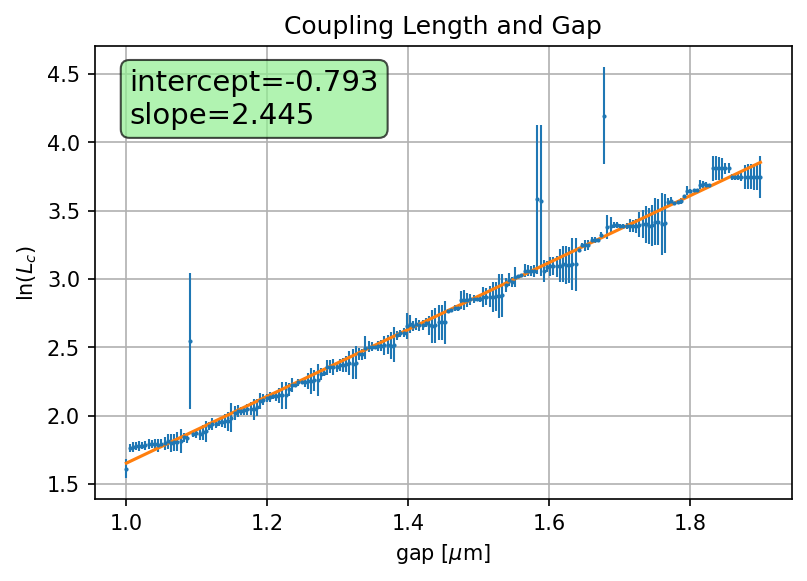

In [55]:
logLc = np.log(Lc)

#propagate the error

d_logLc = d_Lc / Lc  

# Linear Fit

slope, intercept, r, p, se = spst.linregress(gap_array, logLc, alternative='greater')

# Make a figure

fig, ax = plt.subplots(dpi=150)
plt.errorbar(x=gap_array, y=logLc, yerr=d_logLc, fmt=".", elinewidth = 1, ms="2")
plt.plot(gap_array,  intercept + slope*gap_array)
plt.xlabel(r"gap [$\mu$m]")
plt.ylabel(r"$\ln(L_c)$")
plt.title("Coupling Length and Gap")
plt.grid()
# Add textbox

textstr = '\n'.join((
    'intercept=%.3f' % (intercept, ),
    'slope=%.3f' % (slope, )))

props = dict(boxstyle='round', facecolor='lightgreen', alpha=0.7)

ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.savefig("length_vs_gap_lowres.png", dpi=150, format="png")

plt.show()


# Now Iterate Again

This time, what changes is the index contrast between the guides and the surrounding air.

In [14]:
# Iterative procedure 

# Array for values of the index to test 
gs = 100
rind_array = np.linspace(1.1,1.8,gs)

# Start by defining the simulation domain

sx = 80
sy = 8

# Meep function to define the domain. 

cell = mp.Vector3(sx, sy)

center = 0

width = 1

gap = 1.0 # Fixed value of the gap

# Boundary condition, we use PML layer

pml_layer = [mp.PML(1.0) ] # The pml thickness should be of the order of the wavelength 

resolution = 14

# Subvolume for the sensor 

sensor = mp.Vector3(sx, sy/8)

# Wectors to store the coupling length

Lc = np.zeros(gs)
d_Lc = np.zeros(gs)

i = 0

# Define a source

sources = [mp.Source(mp.ContinuousSource(frequency=0.15), # Type of source
                    component = mp.Ez, 
                    size = mp.Vector3(0,width,0),
                    center = mp.Vector3(-7,-gap/2))] # Position

for rind in rind_array: 
    
    geometry = [
       # Guide 1
           mp.Block(
           mp.Vector3(mp.inf, 1, mp.inf), #
           center = mp.Vector3(center,gap/2,0),  
           material = mp.Medium(index=rind)),
        # Guide 2
           mp.Block(
           mp.Vector3(mp.inf, width, mp.inf), #
           center = mp.Vector3(center,-gap/2,0),  
           material = mp.Medium(index=rind)),] 


    # Simulation
    
    sim = mp.Simulation(
          cell_size = cell,
          boundary_layers = pml_layer,
          geometry = geometry,
          sources = sources,
          resolution = resolution)
    
    sim.run(until = 300) # RUn for 300 time steps
    
    # Get field component

    field_up = np.array(sim.get_array(center=mp.Vector3(0, gap/2,0), size=sensor, component=mp.Ez))
    field_down = np.array(sim.get_array(center=mp.Vector3(0, -gap/2,0), size=sensor, component=mp.Ez))
    
    # Integrate along y axis and Hilbert transform
    
    field_up_0 = np.trapz(field_up, axis = 1) #/ (sy/8)
    field_down_0 = np.trapz(field_down, axis = 1) #/ (sy/8)

    envelope_down = np.abs(sp.hilbert(field_down_0))
    envelope_up = np.abs(sp.hilbert(field_up_0))
    
    x = np.linspace(0,sx,sx*10)

        # Finding peaks with scipy function

    height_up_min = 0.9 * np.max(envelope_up)
    height_up_max = 1 * np.max(envelope_up)
    height_down_min = 0.9 * np.max(envelope_down[np.argmax(envelope_down[0:int(np.floor(len(envelope_down)/3))])*2:])
    height_down_max = 1 * np.max(envelope_down[np.argmax(envelope_down[0:int(np.floor(len(envelope_down)/3))])*2:])

    pk_width = 50

    peaks_up = sp.find_peaks(envelope_up, height = (height_up_min, height_up_max), width = pk_width)[0]
    peaks_down = sp.find_peaks(envelope_down, height = (height_down_min, height_down_max), width = pk_width)[0]

    # Computing the coupling length 
    
    while (len(peaks_up) != len(peaks_down)):

        if (len(peaks_up) > len(peaks_down)):

            peaks_up = np.delete(peaks_up, 0)

        elif (len(peaks_down) > len(peaks_up)):
        
            peaks_down = np.delete(peaks_down, len(peaks_down)-1)
            
    dist = np.mean(np.abs(peaks_up - peaks_down))
    d_dist = np.std(np.abs(peaks_up - peaks_down))

    Lc[i] = dist * (sx/len(x))
    d_Lc[i] = d_dist * (sx/len(x))
    
    i += 1
    

-----------
Initializing structure...
time for choose_chunkdivision = 0.000319004 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.21,1.21,1.21)
time for set_epsilon = 0.207678 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 205.0/300.0 = 68.3% done in 4.0s, 1.9s to go
on time step 5749 (time=205.321), 0.000695811 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247002 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.22561,1.22561,1.22561)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.22561,1.22561,1.22561)


/home/diego/anaconda3/envs/photonics_lab/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/diego/anaconda3/envs/photonics_lab/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/diego/anaconda3/envs/photonics_lab/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/diego/anaconda3/envs/photonics_lab/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/diego/anaconda3/envs/photonics_lab/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret 

time for set_epsilon = 0.194406 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 195.67857142857142/300.0 = 65.2% done in 4.0s, 2.1s to go
on time step 5485 (time=195.893), 0.000729463 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000200033 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.24131,1.24131,1.24131)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.24131,1.24131,1.24131)
time for set_epsilon = 0.203679 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 182.85714285714283/300.0 = 61.0% done in 4.0s, 2.6s to go
on time step 5130 (time=183.214), 0.000779835 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000207901 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.25712,1.25712,1.25712)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.25712,1.25712,1.25712)
time for set_epsilon = 0.201079 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 183.2142857142857/300.0 = 61.1% done in 4.0s, 2.5s to go
on time step 5141 (time=183.607), 0.000778214 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000178099 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.27302,1.27302,1.27302)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.27302,1.27302,1.27302)
time for set_epsilon = 0.204019 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 181.89285714285714/300.0 = 60.6% done in 4.0s, 2.6s to go
on time step 5101 (time=182.179), 0.000784374 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.28903,1.28903,1.28903)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.28903,1.28903,1.28903)
time for set_epsilon = 0.201199 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 179.5/300.0 = 59.8% done in 4.0s, 2.7s to go
on time step 5033 (time=179.75), 0.000794786 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000411034 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.30513,1.30513,1.30513)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.30513,1.30513,1.30513)
time for set_epsilon = 0.205486 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 183.10714285714283/300.0 = 61.0% done in 4.0s, 2.6s to go
on time step 5135 (time=183.393), 0.000779086 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000390053 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.32134,1.32134,1.32134)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.32134,1.32134,1.32134)
time for set_epsilon = 0.201851 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 181.89285714285714/300.0 = 60.6% done in 4.0s, 2.6s to go
on time step 5101 (time=182.179), 0.000784178 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000182867 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.33764,1.33764,1.33764)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.33764,1.33764,1.33764)
time for set_epsilon = 0.213355 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 183.28571428571428/300.0 = 61.1% done in 4.0s, 2.5s to go
on time step 5137 (time=183.464), 0.000778704 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000181198 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.35405,1.35405,1.35405)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.35405,1.35405,1.35405)
time for set_epsilon = 0.203983 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 180.32142857142856/300.0 = 60.1% done in 4.0s, 2.7s to go
on time step 5057 (time=180.607), 0.000791169 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000340939 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.37056,1.37056,1.37056)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.37056,1.37056,1.37056)
time for set_epsilon = 0.201769 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 182.9642857142857/300.0 = 61.0% done in 4.0s, 2.6s to go
on time step 5128 (time=183.143), 0.0007801 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000324965 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.38716,1.38716,1.38716)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.38716,1.38716,1.38716)
time for set_epsilon = 0.203982 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 184.28571428571428/300.0 = 61.4% done in 4.0s, 2.5s to go
on time step 5165 (time=184.464), 0.000774492 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000313997 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.40387,1.40387,1.40387)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.40387,1.40387,1.40387)
time for set_epsilon = 0.204835 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 183.0/300.0 = 61.0% done in 4.0s, 2.6s to go
on time step 5131 (time=183.25), 0.00077984 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000275135 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.42067,1.42067,1.42067)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.42067,1.42067,1.42067)
time for set_epsilon = 0.201351 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 181.10714285714286/300.0 = 60.4% done in 4.0s, 2.6s to go
on time step 5078 (time=181.357), 0.000787825 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000181913 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.43758,1.43758,1.43758)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.43758,1.43758,1.43758)
time for set_epsilon = 0.204198 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 181.64285714285714/300.0 = 60.5% done in 4.0s, 2.6s to go
on time step 5094 (time=181.929), 0.000785334 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000235081 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.45458,1.45458,1.45458)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.45458,1.45458,1.45458)
time for set_epsilon = 0.203841 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 182.9642857142857/300.0 = 61.0% done in 4.0s, 2.6s to go
on time step 5127 (time=183.107), 0.00078022 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000332832 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.47169,1.47169,1.47169)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.47169,1.47169,1.47169)
time for set_epsilon = 0.218729 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 179.60714285714286/300.0 = 59.9% done in 4.0s, 2.7s to go
on time step 5033 (time=179.75), 0.000794779 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000217199 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.48889,1.48889,1.48889)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.48889,1.48889,1.48889)
time for set_epsilon = 0.210459 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 178.60714285714286/300.0 = 59.5% done in 4.0s, 2.7s to go
on time step 5005 (time=178.75), 0.000799242 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000187159 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.5062,1.5062,1.5062)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.5062,1.5062,1.5062)
time for set_epsilon = 0.213359 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 178.67857142857142/300.0 = 59.6% done in 4.0s, 2.7s to go
on time step 5011 (time=178.964), 0.000798374 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000219822 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.5236,1.5236,1.5236)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.5236,1.5236,1.5236)
time for set_epsilon = 0.206582 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 179.75/300.0 = 59.9% done in 4.0s, 2.7s to go
on time step 5040 (time=180), 0.000793718 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000371218 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.54111,1.54111,1.54111)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.54111,1.54111,1.54111)
time for set_epsilon = 0.206538 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 178.64285714285714/300.0 = 59.5% done in 4.0s, 2.7s to go
on time step 5012 (time=179), 0.000798204 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000224829 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.55871,1.55871,1.55871)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.55871,1.55871,1.55871)
time for set_epsilon = 0.206037 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 177.78571428571428/300.0 = 59.3% done in 4.0s, 2.7s to go
on time step 4985 (time=178.036), 0.000802468 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00017786 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.57642,1.57642,1.57642)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.57642,1.57642,1.57642)
time for set_epsilon = 0.207918 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 178.17857142857142/300.0 = 59.4% done in 4.0s, 2.7s to go
on time step 4997 (time=178.464), 0.000800574 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000228167 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.59423,1.59423,1.59423)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.59423,1.59423,1.59423)
time for set_epsilon = 0.204343 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 183.85714285714283/300.0 = 61.3% done in 4.0s, 2.5s to go
on time step 5158 (time=184.214), 0.000775571 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000244141 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.61213,1.61213,1.61213)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.61213,1.61213,1.61213)
time for set_epsilon = 0.201995 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 186.9642857142857/300.0 = 62.3% done in 4.0s, 2.4s to go
on time step 5243 (time=187.25), 0.000762961 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.63014,1.63014,1.63014)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.63014,1.63014,1.63014)
time for set_epsilon = 0.184904 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 221.60714285714283/300.0 = 73.9% done in 4.0s, 1.4s to go
on time step 6212 (time=221.857), 0.000643979 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000282049 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.64824,1.64824,1.64824)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.64824,1.64824,1.64824)
time for set_epsilon = 0.187369 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 220.10714285714283/300.0 = 73.4% done in 4.0s, 1.5s to go
on time step 6171 (time=220.393), 0.000648289 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000185013 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.66645,1.66645,1.66645)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.66645,1.66645,1.66645)
time for set_epsilon = 0.179555 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 220.35714285714283/300.0 = 73.5% done in 4.0s, 1.4s to go
on time step 6177 (time=220.607), 0.000647567 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265837 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.68475,1.68475,1.68475)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.68475,1.68475,1.68475)
time for set_epsilon = 0.18851 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 218.14285714285714/300.0 = 72.7% done in 4.0s, 1.5s to go
on time step 6116 (time=218.429), 0.000654143 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000204802 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.70316,1.70316,1.70316)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.70316,1.70316,1.70316)
time for set_epsilon = 0.18093 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 219.57142857142856/300.0 = 73.2% done in 4.0s, 1.5s to go
on time step 6156 (time=219.857), 0.000649791 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000181913 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.72166,1.72166,1.72166)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.72166,1.72166,1.72166)
time for set_epsilon = 0.187034 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 212.14285714285714/300.0 = 70.7% done in 4.0s, 1.7s to go
on time step 5945 (time=212.321), 0.000672842 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000236988 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.74027,1.74027,1.74027)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.74027,1.74027,1.74027)
time for set_epsilon = 0.19399 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 195.10714285714283/300.0 = 65.0% done in 4.0s, 2.2s to go
on time step 5471 (time=195.393), 0.000731289 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.75897,1.75897,1.75897)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.75897,1.75897,1.75897)
time for set_epsilon = 0.196467 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 190.53571428571428/300.0 = 63.5% done in 4.0s, 2.3s to go
on time step 5341 (time=190.75), 0.000748962 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000200033 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.77778,1.77778,1.77778)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.77778,1.77778,1.77778)
time for set_epsilon = 0.190424 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 194.78571428571428/300.0 = 64.9% done in 4.0s, 2.2s to go
on time step 5459 (time=194.964), 0.000732772 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000210047 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.79668,1.79668,1.79668)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.79668,1.79668,1.79668)
time for set_epsilon = 0.200898 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 186.60714285714283/300.0 = 62.2% done in 4.0s, 2.4s to go
on time step 5230 (time=186.786), 0.000764843 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277042 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.81569,1.81569,1.81569)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.81569,1.81569,1.81569)
time for set_epsilon = 0.207477 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 174.9642857142857/300.0 = 58.3% done in 4.0s, 2.9s to go
on time step 4905 (time=175.179), 0.000815588 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.83479,1.83479,1.83479)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.83479,1.83479,1.83479)
time for set_epsilon = 0.211432 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 187.5/300.0 = 62.5% done in 4.0s, 2.4s to go
on time step 5260 (time=187.857), 0.000760619 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000510931 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.854,1.854,1.854)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.854,1.854,1.854)
time for set_epsilon = 0.197638 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 186.85714285714283/300.0 = 62.3% done in 4.0s, 2.4s to go
on time step 5239 (time=187.107), 0.000763776 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000216961 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.8733,1.8733,1.8733)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.8733,1.8733,1.8733)
time for set_epsilon = 0.207784 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 181.14285714285714/300.0 = 60.4% done in 4.0s, 2.6s to go
on time step 5079 (time=181.393), 0.000787724 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000197172 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.89271,1.89271,1.89271)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.89271,1.89271,1.89271)
time for set_epsilon = 0.224271 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 204.39285714285714/300.0 = 68.1% done in 4.0s, 1.9s to go
on time step 5731 (time=204.679), 0.00069799 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000723124 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.91221,1.91221,1.91221)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.91221,1.91221,1.91221)
time for set_epsilon = 0.185548 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 224.64285714285714/300.0 = 74.9% done in 4.0s, 1.3s to go
on time step 6298 (time=224.929), 0.000635238 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000237942 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.93182,1.93182,1.93182)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.93182,1.93182,1.93182)
time for set_epsilon = 0.186182 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 226.32142857142856/300.0 = 75.4% done in 4.0s, 1.3s to go
on time step 6344 (time=226.571), 0.000630563 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000294924 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.95152,1.95152,1.95152)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.95152,1.95152,1.95152)
time for set_epsilon = 0.182171 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 226.82142857142856/300.0 = 75.6% done in 4.0s, 1.3s to go
on time step 6351 (time=226.821), 0.00063003 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000386953 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.97133,1.97133,1.97133)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.97133,1.97133,1.97133)
time for set_epsilon = 0.216248 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 188.9642857142857/300.0 = 63.0% done in 4.0s, 2.4s to go
on time step 5297 (time=189.179), 0.000755181 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000332832 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.99123,1.99123,1.99123)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.99123,1.99123,1.99123)
time for set_epsilon = 0.219225 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 189.82142857142856/300.0 = 63.3% done in 4.0s, 2.3s to go
on time step 5321 (time=190.036), 0.000751769 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000295877 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.01124,2.01124,2.01124)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.01124,2.01124,2.01124)
time for set_epsilon = 0.219897 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 190.2142857142857/300.0 = 63.4% done in 4.0s, 2.3s to go
on time step 5334 (time=190.5), 0.000750045 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000205994 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.03134,2.03134,2.03134)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.03134,2.03134,2.03134)
time for set_epsilon = 0.215819 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 191.78571428571428/300.0 = 63.9% done in 4.0s, 2.3s to go
on time step 5377 (time=192.036), 0.000743911 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000391006 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.05155,2.05155,2.05155)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.05155,2.05155,2.05155)
time for set_epsilon = 0.216716 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 192.67857142857142/300.0 = 64.2% done in 4.0s, 2.2s to go
on time step 5401 (time=192.893), 0.000740645 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000226974 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.07185,2.07185,2.07185)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.07185,2.07185,2.07185)
time for set_epsilon = 0.216102 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 190.2142857142857/300.0 = 63.4% done in 4.0s, 2.3s to go
on time step 5333 (time=190.464), 0.000750176 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000233889 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.09226,2.09226,2.09226)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.09226,2.09226,2.09226)
time for set_epsilon = 0.221556 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 190.64285714285714/300.0 = 63.5% done in 4.0s, 2.3s to go
on time step 5346 (time=190.929), 0.000748239 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000236034 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.11277,2.11277,2.11277)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.11277,2.11277,2.11277)
time for set_epsilon = 0.219784 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 193.28571428571428/300.0 = 64.4% done in 4.0s, 2.2s to go
on time step 5419 (time=193.536), 0.000738152 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000205994 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.13337,2.13337,2.13337)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.13337,2.13337,2.13337)
time for set_epsilon = 0.218902 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 192.82142857142856/300.0 = 64.3% done in 4.0s, 2.2s to go
on time step 5406 (time=193.071), 0.000740078 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000240088 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.15408,2.15408,2.15408)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.15408,2.15408,2.15408)
time for set_epsilon = 0.221281 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 191.4642857142857/300.0 = 63.8% done in 4.0s, 2.3s to go
on time step 5367 (time=191.679), 0.000745351 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000222921 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.17488,2.17488,2.17488)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.17488,2.17488,2.17488)
time for set_epsilon = 0.215805 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 192.85714285714283/300.0 = 64.3% done in 4.0s, 2.2s to go
on time step 5406 (time=193.071), 0.000739941 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000210047 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.19579,2.19579,2.19579)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.19579,2.19579,2.19579)
time for set_epsilon = 0.218331 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 192.03571428571428/300.0 = 64.0% done in 4.0s, 2.2s to go
on time step 5383 (time=192.25), 0.00074315 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249147 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.21679,2.21679,2.21679)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.21679,2.21679,2.21679)
time for set_epsilon = 0.216308 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 193.53571428571428/300.0 = 64.5% done in 4.0s, 2.2s to go
on time step 5425 (time=193.75), 0.000737345 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000236988 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.2379,2.2379,2.2379)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.2379,2.2379,2.2379)
time for set_epsilon = 0.21627 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 192.82142857142856/300.0 = 64.3% done in 4.0s, 2.2s to go
on time step 5405 (time=193.036), 0.00074008 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000389814 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.2591,2.2591,2.2591)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.2591,2.2591,2.2591)
time for set_epsilon = 0.215916 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 193.25/300.0 = 64.4% done in 4.0s, 2.2s to go
on time step 5418 (time=193.5), 0.000738382 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00039196 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.28041,2.28041,2.28041)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.28041,2.28041,2.28041)
time for set_epsilon = 0.215948 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 190.53571428571428/300.0 = 63.5% done in 4.0s, 2.3s to go
on time step 5343 (time=190.821), 0.000748744 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000236988 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.30181,2.30181,2.30181)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.30181,2.30181,2.30181)
time for set_epsilon = 0.221181 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 192.64285714285714/300.0 = 64.2% done in 4.0s, 2.2s to go
on time step 5402 (time=192.929), 0.000740586 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000206947 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.32331,2.32331,2.32331)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.32331,2.32331,2.32331)
time for set_epsilon = 0.21698 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 192.28571428571428/300.0 = 64.1% done in 4.0s, 2.2s to go
on time step 5390 (time=192.5), 0.000742169 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.34492,2.34492,2.34492)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.34492,2.34492,2.34492)
time for set_epsilon = 0.219539 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 190.07142857142856/300.0 = 63.4% done in 4.0s, 2.3s to go
on time step 5327 (time=190.25), 0.000750894 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00020504 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.36662,2.36662,2.36662)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.36662,2.36662,2.36662)
time for set_epsilon = 0.217466 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 191.39285714285714/300.0 = 63.8% done in 4.0s, 2.3s to go
on time step 5366 (time=191.643), 0.000745581 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000205994 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.38843,2.38843,2.38843)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.38843,2.38843,2.38843)
time for set_epsilon = 0.218423 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 191.32142857142856/300.0 = 63.8% done in 4.0s, 2.3s to go
on time step 5363 (time=191.536), 0.000746031 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000207186 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.41033,2.41033,2.41033)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.41033,2.41033,2.41033)
time for set_epsilon = 0.217153 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 191.75/300.0 = 63.9% done in 4.0s, 2.3s to go
on time step 5375 (time=191.964), 0.000744237 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000219822 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.43234,2.43234,2.43234)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.43234,2.43234,2.43234)
time for set_epsilon = 0.21625 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 188.42857142857142/300.0 = 62.8% done in 4.0s, 2.4s to go
on time step 5282 (time=188.643), 0.000757326 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000205994 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.45444,2.45444,2.45444)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.45444,2.45444,2.45444)
time for set_epsilon = 0.219586 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 190.9642857142857/300.0 = 63.7% done in 4.0s, 2.3s to go
on time step 5355 (time=191.25), 0.000746968 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000241995 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.47665,2.47665,2.47665)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.47665,2.47665,2.47665)
time for set_epsilon = 0.216365 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 192.64285714285714/300.0 = 64.2% done in 4.0s, 2.2s to go
on time step 5400 (time=192.857), 0.000740798 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000224113 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.49895,2.49895,2.49895)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.49895,2.49895,2.49895)
time for set_epsilon = 0.215777 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 192.14285714285714/300.0 = 64.0% done in 4.0s, 2.2s to go
on time step 5387 (time=192.393), 0.000742539 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000393867 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.52136,2.52136,2.52136)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.52136,2.52136,2.52136)
time for set_epsilon = 0.216251 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 191.07142857142856/300.0 = 63.7% done in 4.0s, 2.3s to go
on time step 5358 (time=191.357), 0.000746629 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000211 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.54386,2.54386,2.54386)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.54386,2.54386,2.54386)
time for set_epsilon = 0.219679 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 190.67857142857142/300.0 = 63.6% done in 4.0s, 2.3s to go
on time step 5344 (time=190.857), 0.000748605 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000208139 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.56647,2.56647,2.56647)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.56647,2.56647,2.56647)
time for set_epsilon = 0.216927 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 193.0/300.0 = 64.3% done in 4.0s, 2.2s to go
on time step 5410 (time=193.214), 0.000739426 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000205994 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.58917,2.58917,2.58917)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.58917,2.58917,2.58917)
time for set_epsilon = 0.215846 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 190.75/300.0 = 63.6% done in 4.0s, 2.3s to go
on time step 5351 (time=191.107), 0.00074756 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000203848 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.61198,2.61198,2.61198)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.61198,2.61198,2.61198)
time for set_epsilon = 0.218384 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 192.85714285714283/300.0 = 64.3% done in 4.0s, 2.2s to go
on time step 5407 (time=193.107), 0.00073981 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000326872 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.63488,2.63488,2.63488)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.63488,2.63488,2.63488)
time for set_epsilon = 0.2224 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 191.4642857142857/300.0 = 63.8% done in 4.0s, 2.3s to go
on time step 5371 (time=191.821), 0.000744816 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000383139 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.65789,2.65789,2.65789)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.65789,2.65789,2.65789)
time for set_epsilon = 0.219658 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 192.25/300.0 = 64.1% done in 4.0s, 2.2s to go
on time step 5389 (time=192.464), 0.000742318 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000367165 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.68099,2.68099,2.68099)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.68099,2.68099,2.68099)
time for set_epsilon = 0.220191 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 190.42857142857142/300.0 = 63.5% done in 4.0s, 2.3s to go
on time step 5340 (time=190.714), 0.000749121 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000375032 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.7042,2.7042,2.7042)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.7042,2.7042,2.7042)
time for set_epsilon = 0.216147 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 193.25/300.0 = 64.4% done in 4.0s, 2.2s to go
on time step 5416 (time=193.429), 0.000738557 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000205994 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.7275,2.7275,2.7275)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.7275,2.7275,2.7275)
time for set_epsilon = 0.216753 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 190.92857142857142/300.0 = 63.6% done in 4.0s, 2.3s to go
on time step 5352 (time=191.143), 0.000747464 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00020504 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.75091,2.75091,2.75091)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.75091,2.75091,2.75091)
time for set_epsilon = 0.220436 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 191.53571428571428/300.0 = 63.8% done in 4.0s, 2.3s to go
on time step 5369 (time=191.75), 0.000745054 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.77441,2.77441,2.77441)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.77441,2.77441,2.77441)
time for set_epsilon = 0.216657 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 190.92857142857142/300.0 = 63.6% done in 4.0s, 2.3s to go
on time step 5355 (time=191.25), 0.000747053 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000206947 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.79802,2.79802,2.79802)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.79802,2.79802,2.79802)
time for set_epsilon = 0.217123 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 191.82142857142856/300.0 = 63.9% done in 4.0s, 2.3s to go
on time step 5377 (time=192.036), 0.000743987 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000207186 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.82172,2.82172,2.82172)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.82172,2.82172,2.82172)
time for set_epsilon = 0.216319 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 191.17857142857142/300.0 = 63.7% done in 4.0s, 2.3s to go
on time step 5360 (time=191.429), 0.000746281 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000205994 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.84553,2.84553,2.84553)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.84553,2.84553,2.84553)
time for set_epsilon = 0.21587 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 192.39285714285714/300.0 = 64.1% done in 4.0s, 2.2s to go
on time step 5394 (time=192.643), 0.000741594 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000225067 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.86943,2.86943,2.86943)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.86943,2.86943,2.86943)
time for set_epsilon = 0.224668 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 191.14285714285714/300.0 = 63.7% done in 4.0s, 2.3s to go
on time step 5357 (time=191.321), 0.000746757 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000206947 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89344,2.89344,2.89344)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89344,2.89344,2.89344)
time for set_epsilon = 0.21626 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 189.7142857142857/300.0 = 63.2% done in 4.0s, 2.3s to go
on time step 5317 (time=189.893), 0.00075237 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000205994 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.91754,2.91754,2.91754)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.91754,2.91754,2.91754)
time for set_epsilon = 0.216628 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 182.89285714285714/300.0 = 61.0% done in 4.0s, 2.6s to go
on time step 5129 (time=183.179), 0.000779898 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000246048 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.94174,2.94174,2.94174)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.94174,2.94174,2.94174)
time for set_epsilon = 0.21598 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 186.07142857142856/300.0 = 62.0% done in 4.0s, 2.4s to go
on time step 5216 (time=186.286), 0.000766969 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000204086 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.96605,2.96605,2.96605)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.96605,2.96605,2.96605)
time for set_epsilon = 0.215963 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 191.5/300.0 = 63.8% done in 4.0s, 2.3s to go
on time step 5369 (time=191.75), 0.000745019 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000202894 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.99045,2.99045,2.99045)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.99045,2.99045,2.99045)
time for set_epsilon = 0.223286 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 192.57142857142856/300.0 = 64.2% done in 4.0s, 2.2s to go
on time step 5399 (time=192.821), 0.000740946 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000213861 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.01496,3.01496,3.01496)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.01496,3.01496,3.01496)
time for set_epsilon = 0.216387 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 192.57142857142856/300.0 = 64.2% done in 4.0s, 2.2s to go
on time step 5398 (time=192.786), 0.000741072 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000206947 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.03956,3.03956,3.03956)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.03956,3.03956,3.03956)
time for set_epsilon = 0.216975 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 192.67857142857142/300.0 = 64.2% done in 4.0s, 2.2s to go
on time step 5403 (time=192.964), 0.000740337 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000206947 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.06427,3.06427,3.06427)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.06427,3.06427,3.06427)
time for set_epsilon = 0.217329 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 192.57142857142856/300.0 = 64.2% done in 4.0s, 2.2s to go
on time step 5399 (time=192.821), 0.0007409 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000216961 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.08907,3.08907,3.08907)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.08907,3.08907,3.08907)
time for set_epsilon = 0.216874 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 190.17857142857142/300.0 = 63.4% done in 4.0s, 2.3s to go
on time step 5332 (time=190.429), 0.0007502 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000209093 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.11398,3.11398,3.11398)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.11398,3.11398,3.11398)
time for set_epsilon = 0.220385 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 191.67857142857142/300.0 = 63.9% done in 4.0s, 2.3s to go
on time step 5374 (time=191.929), 0.000744489 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000206947 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.13898,3.13898,3.13898)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.13898,3.13898,3.13898)
time for set_epsilon = 0.216855 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 192.85714285714283/300.0 = 64.3% done in 4.0s, 2.2s to go
on time step 5407 (time=193.107), 0.000739805 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000353098 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.16409,3.16409,3.16409)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.16409,3.16409,3.16409)
time for set_epsilon = 0.219892 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 191.14285714285714/300.0 = 63.7% done in 4.0s, 2.3s to go
on time step 5360 (time=191.429), 0.000746413 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00020504 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.18929,3.18929,3.18929)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.18929,3.18929,3.18929)
time for set_epsilon = 0.218657 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 188.0/300.0 = 62.7% done in 4.0s, 2.4s to go
on time step 5269 (time=188.179), 0.000759213 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00039196 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.2146,3.2146,3.2146)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.2146,3.2146,3.2146)
time for set_epsilon = 0.219066 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 190.64285714285714/300.0 = 63.5% done in 4.0s, 2.3s to go
on time step 5347 (time=190.964), 0.000748199 s/step
run 0 finished at t = 300.0 (8400 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000361204 s
Working in 2D dimensions.
Computational cell is 80 x 8 x 0 with resolution 14
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
time for set_epsilon = 0.216383 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 189.9642857142857/300.0 = 63.3% done in 4.0s, 2.3s to go
on time step 5328 (time=190.286), 0.000750871 s/step
run 0 finished at t = 300.0 (8400 timesteps)


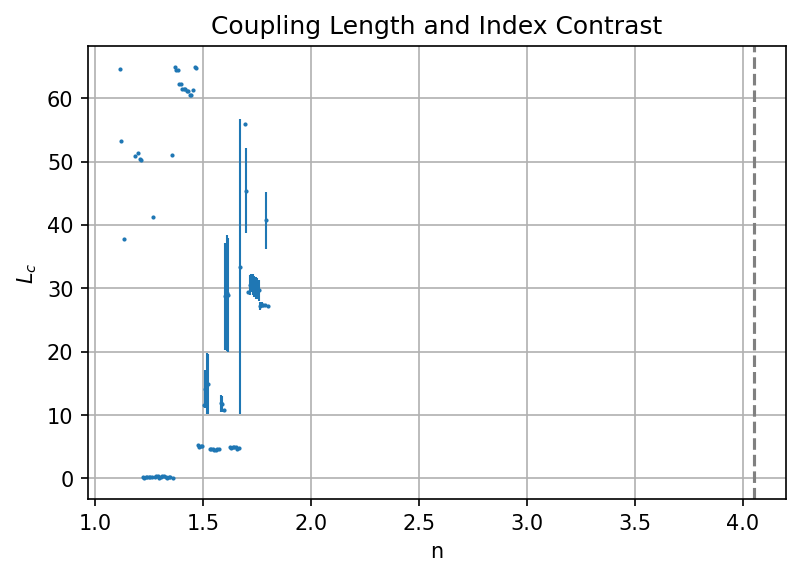

In [15]:
# Make a figure

fig, ax = plt.subplots(dpi=150)
plt.errorbar(x=rind_array, y=Lc, yerr=d_Lc, fmt=".", elinewidth = 1, ms="2")
plt.xlabel("n")
plt.ylabel(r"$L_c$")
plt.title("Coupling Length and Index Contrast")
plt.axvline(4.05, color = "grey", ls="--")
plt.grid()

plt.savefig("length_vs_index_prob.png", dpi=150, format="png")

plt.show()

In [16]:
# Remove NaN

rind_array = rind_array[np.logical_not(np.isnan(Lc))]
Lc = Lc[np.logical_not(np.isnan(Lc))]
d_Lc = d_Lc[np.logical_not(np.isnan(d_Lc))]


# Indices of problematic values

rm_arr = []

mn = np.mean(d_Lc)
mn1 = np.mean(Lc) 

for i in range(0, len(Lc)):
    
    if (d_Lc[i] > mn):
        
        rm_arr.append(i)
        
    elif (Lc[i] > 1.3 * mn1):
        
        rm_arr.append(i)
        
rm_arr

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 14,
 26,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 48,
 49,
 50,
 58,
 59,
 61,
 62,
 63,
 71,
 72,
 73,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 86]

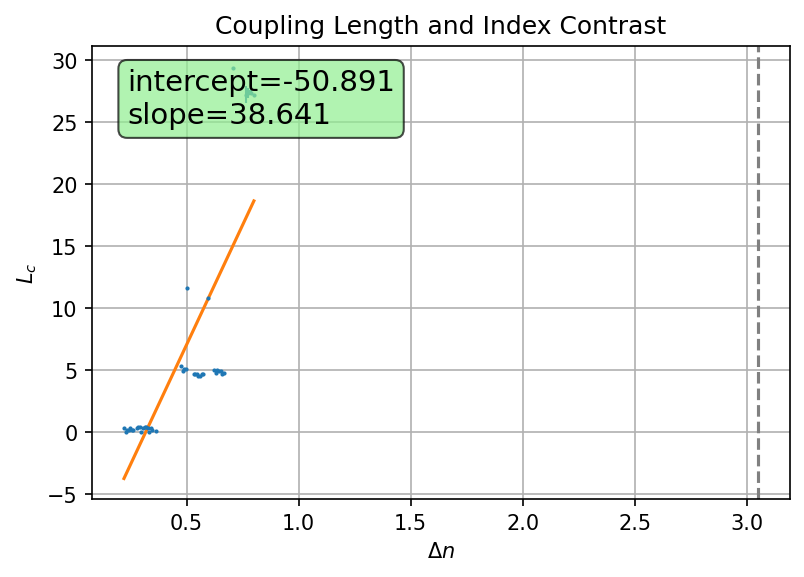

In [17]:
# Removing the Problematic points

Lc_mod = np.delete(Lc, rm_arr)
d_Lc_mod = np.delete(d_Lc, rm_arr)
rind_array_mod = np.delete(rind_array, rm_arr)

indcon = rind_array_mod - np.ones(len(rind_array_mod)) 

# Linear Fit

slope, intercept, r, p, se = spst.linregress(rind_array_mod, Lc_mod, alternative='greater')

# Make a figure

fig1, ax = plt.subplots(dpi=150)
plt.errorbar(x=indcon, y=Lc_mod, yerr=d_Lc_mod, fmt=".", elinewidth = 1, ms="2")
plt.plot(indcon,  intercept + slope*rind_array_mod)
plt.xlabel(r"$\Delta n$")
plt.ylabel(r"$L_c$")
plt.title("Coupling Length and Index Contrast")
plt.axvline(4.05-1, color = "grey", ls="--")
plt.grid()

# Add textbox

textstr = '\n'.join((
    'intercept=%.3f' % (intercept, ),
    'slope=%.3f' % (slope, )))

props = dict(boxstyle='round', facecolor='lightgreen', alpha=0.7)

ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.savefig("length_vs_index", dpi=150, format="png")

plt.show()